In [1]:
import sys

import pandas as pd

import superlets_package.superlets

sys.path.insert(0, '..')

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import importlib
import time

import superlets_package.morlet as superlets_module_morlet
import superlets_package.superlets as superlet

#from superlets_package.superlets import wavelet_transform, adaptive_superlet_transform, fdeluca_changing, compute_psd_welch, meanfreq, instant_mean

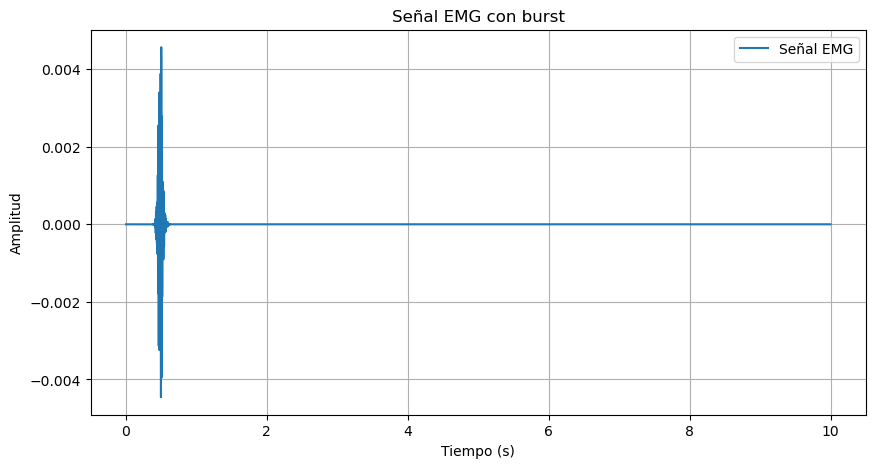

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Parámetros de la señal
fs = 1024  # Frecuencia de muestreo en Hz
duration = 10  # Duración de la señal en segundos
mean_freq = 110  # Frecuencia media en Hz
burst_duration = 0.2  # Duración del burst en segundos
burst_center = 0.5  # Centro del burst en segundos

# Tiempo
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Envolvente gaussiana
envelope = np.exp(-((t - burst_center) ** 2) / (2 * (burst_duration / 6) ** 2))

# Ruido blanco
noise = np.random.normal(0, 0.01, len(t))

# Filtro pasa banda
lowcut = mean_freq - 20  # Límite inferior
highcut = mean_freq + 20  # Límite superior


def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)


# Filtrar ruido blanco
filtered_noise = butter_bandpass_filter(noise, lowcut, highcut, fs)

# Señal burst
burst_signal = filtered_noise * envelope

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(t, burst_signal, label="Señal EMG")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal EMG con burst")
plt.legend()
plt.grid()
plt.show()

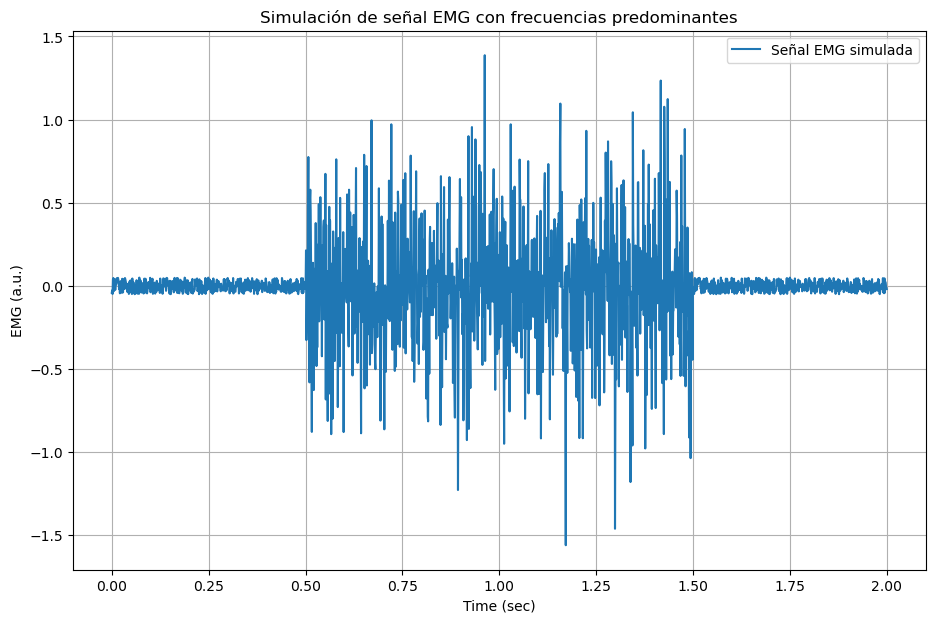

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fs = 1000  # Frecuencia de muestreo en Hz
t_burst = 1  # Duración de cada "burst" en segundos
f_burst1 = 110  # Frecuencia del primer "burst" en Hz
#f_burst2 = 120  # Frecuencia del segundo "burst" en Hz
amplitude = 1

# simulate EMG signal
# burst1 = np.random.uniform(-1, 1, size=1000) + 0.08
# burst2 = np.random.uniform(-1, 1, size=1000) + 0.08
t_burst1 = np.linspace(0, t_burst, int(fs * t_burst), endpoint=False)
#t_burst2 = np.linspace(0, t_burst, int(fs * t_burst), endpoint=False)

# Generar ruido gaussiano
noise1 = np.random.normal(0, 0.5, len(t_burst1))
#noise2 = np.random.normal(0, 0.5, len(t_burst2))

# Envolvente sinusoidal para los bursts
envelope1 = amplitude * np.sin(2 * np.pi * f_burst1 * t_burst1)
#envelope2 = amplitude * np.sin(2 * np.pi * f_burst2 * t_burst2)

# Crear bursts modulados con ruido
burst1 = envelope1 * noise1
#burst2 = envelope2 * noise2

# Período de reposo (ruido bajo)
quiet = np.random.uniform(-0.05, 0.05, size=int(fs * 0.5)) + 0.08

# Combinar la señal
emg = np.concatenate([quiet, burst1, quiet])
time = np.linspace(0, len(emg) / fs, len(emg))

# Graficar la señal EMG
fig = plt.figure()
plt.plot(time, emg, label="Señal EMG simulada")
plt.xlabel('Time (sec)')
plt.ylabel('EMG (a.u.)')
plt.title('Simulación de señal EMG con frecuencias predominantes')
plt.grid(True)
plt.legend()
fig.set_size_inches(w=11, h=7)
fig.savefig('fig2.png')

plt.show()

### Simulated EMG signal sin Modelo de DeLuca

310.6145279929333


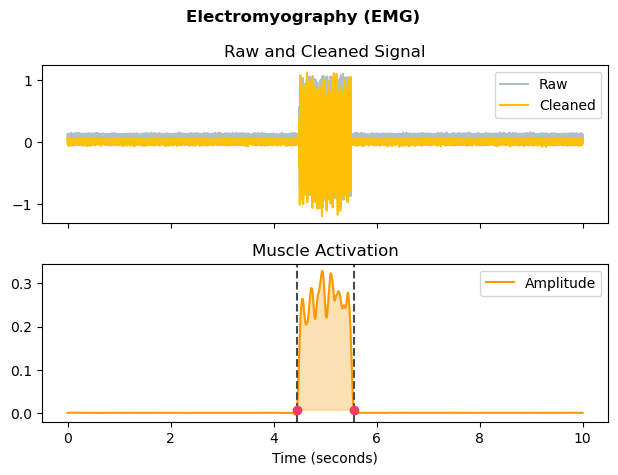

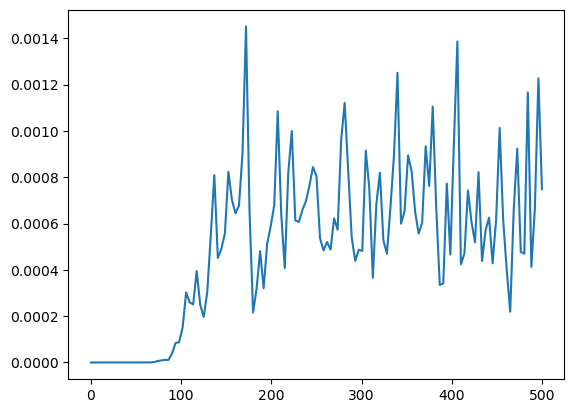

In [21]:
import neurokit2 as nk

emg = nk.emg_simulate(duration=10, sampling_rate=1000, burst_number=1)

signals, info = nk.emg_process(emg, sampling_rate=1000)

nk.emg_plot(signals, info)

emg_clean = signals.EMG_Clean

signal = emg_clean

plt.tight_layout()

activity, info = nk.emg_activation(emg_amplitude=signals.EMG_Amplitude, method="threshold")

nk.events_plot([info["EMG_Offsets"], info["EMG_Onsets"]], emg_clean)


S1, f1 = plt.psd(emg_clean[np.where(activity.EMG_Activity == 1)[0]], NFFT=256, Fs=1000, window=np.hanning(256), noverlap=128)
plt.close()

plt.figure()
plt.plot(f1, S1)
MNF_1 = superlet.meanfreq(S1, f1)
print(MNF_1)

### Simulated EMG signal: Modelo de DeLuca

#### Add noise to the signal with a particular value for SNR

In [120]:
def add_wgn_to_sig(signal, w_g_noise, ssnnrr):
    
    sign_UnitaryVar = (signal - np.mean(signal)) / np.std(signal)
    Pn = np.var(w_g_noise)
    Ps = Pn * (10**(ssnnrr / 10))
    new_signals = np.sqrt(Ps) * sign_UnitaryVar
    noisy_signal = new_signals + w_g_noise

    return noisy_signal


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def add_noise(x, snr, plot = False):
    """
    Add Gaussian random noise to a signal with a specified SNR.

    Parameters:
        x (numpy array): Original signal (vector)
        snr (float): Desired Signal-to-Noise Ratio (in dB)

    Returns:
        numpy array: Signal with added Gaussian noise
    """
    n = len(x)  # Length of the signal
    Px = np.sum(np.abs(x)**2) / n  # Power of the original signal
    Pn = Px / (10**(snr / 10))  # Noise power for the given SNR

    noise = np.sqrt(Pn) * np.random.randn(*x.shape)  # Generate Gaussian noise
    xn = x + noise  # Add noise to the original signal

    # Plot the original and noisy signals
    if plot:
        plt.figure()
        plt.plot(xn, 'r', label='Noisy Signal')
        plt.plot(x, 'b', label='Original Signal')
        plt.legend()
        plt.title(f'Signal with Added White Gaussian Noise (SNR = {snr} dB)')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.show()

    return xn

In [3]:
fs = 1024
t = np.linspace(0, 10, 10 * fs)
noise = np.random.normal(0, 0.01, len(t))  # Gaussian noise
#noise = np.zeros(len(t))
baseline_1 = noise.copy()

In [123]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/CWT_parkison/superlets_package/superlets.py'>

Round value of T to a multiple of 0.25


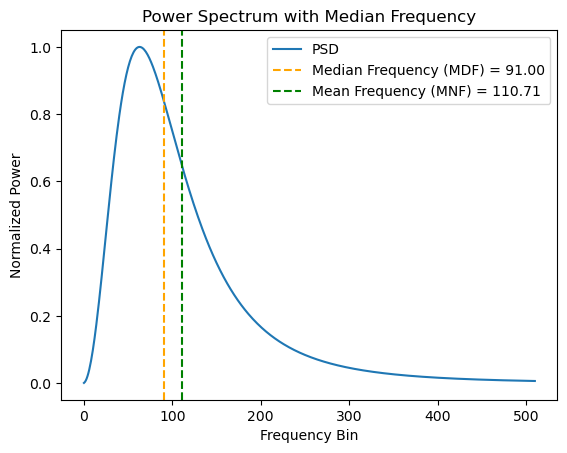

In [124]:
burst_duration_1 = 0.2
burst_start_1 = 2

[Pxx_1, burst_1, MNF_1, MDF_1] = superlet.fdeluca_changing(80, 120, 60, 100, fs, T = burst_duration_1, wind_change = burst_duration_1, plot = True)
# t_1 = np.linspace(0, burst_duration_1, len(burst_1))
# plt.plot(t_1, burst_1)
# plt.title('Burst 1')
# 
# plt.figure()
# plt.plot(noise)
# psd_welch, f_welch = compute_psd_welch(burst_1, fs, plot=True, muscle='Burst 1')

#baseline_1[burst_start_1*fs:burst_start_1*fs + len(burst_1)] += burst_1
baseline_1[burst_start_1*fs:burst_start_1*fs + len(burst_1)] += burst_1
# plt.figure()
# plt.plot(baseline_1)
# plt.title('Baseline + Burst 1')
# 
# plt.figure()
# plt.plot(baseline_1)
# plt.figure()
# psd_welch, f_welch = compute_psd_welch(baseline_1, fs, plot=True, muscle='Baseline + burst_1')

In [49]:
# burst_duration_2 = 3
# burst_start_2 = 5
# 
# [Pxx_2, burst_2, MNF_2, MDF_2] = superlet.fdeluca_changing(100, 140, 80, 120, fs, burst_duration_2, 0.125, plot = True)
# # t_2 = np.linspace(0, burst_duration_2, len(burst_2))
# # plt.plot(t_2, burst_2)
# # plt.title('Burst 2')
# # 
# plt.figure()
# psd_welch, f_welch = superlet.compute_psd_welch(burst_2, fs, plot=True, muscle='Burst 2')
# 
# baseline_1[burst_start_2*fs:burst_start_2*fs + len(burst_2)] += burst_2
# # plt.figure()
# # plt.plot(baseline_1)
# # plt.title('Baseline + Burst 2')

In [50]:
# # High frequency and very fast burst
# burst_duration_3 = 0.5
# burst_start_3 = 8.5
# 
# [Pxx_3, burst_3, MNF_3, MDF_3] = superlet.fdeluca_changing(220, 250, 200, 230, fs, burst_duration_3, 0.125, plot = False)
# # t_3 = np.linspace(0, burst_duration_3, len(burst_3))
# # plt.plot(t_3, burst_3)
# # plt.title('Burst 3')
# # 
# # plt.figure()
# psd_welch, f_welch = superlet.compute_psd_welch(burst_3, fs, plot=True, muscle='Burst 3')
# 
# baseline_1[int(burst_start_3 * fs):int(burst_start_3 * fs + len(burst_3))] += burst_3
# # plt.figure()
# # plt.plot(baseline_1)
# # plt.title('Baseline + Burst 3')

In [12]:
signal = burst_signal

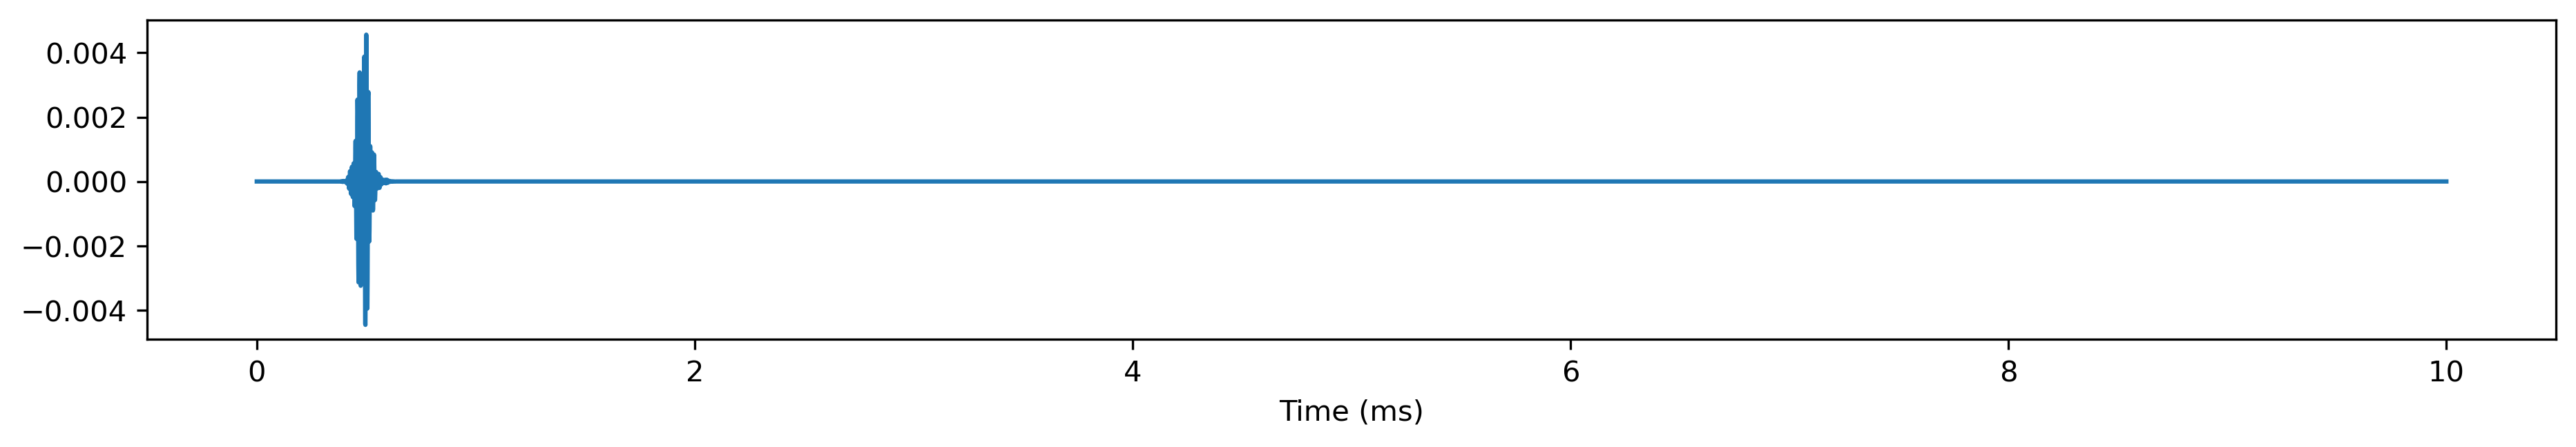

In [5]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal)/fs, len(signal)), signal)
#print(f"Reference mean frequency: {MNF_1[0]} Hz")

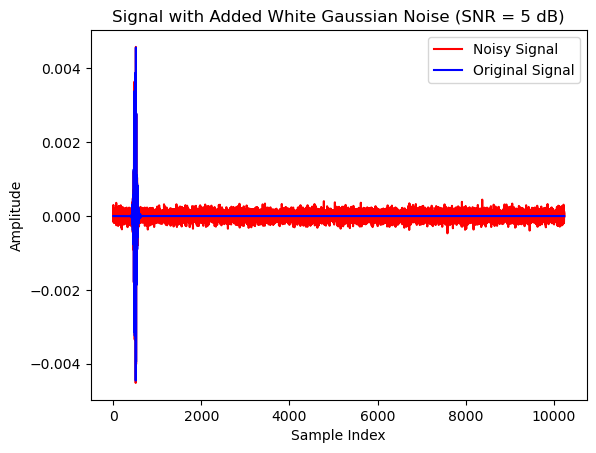

In [13]:
SNR = 5
#signal_noise = add_noise(baseline_1, SNR, plot = True)
signal_noise = add_noise(signal, SNR, plot = True)
#signal_noise = add_wgn_to_sig(baseline_1, noise, SNR)
signal = signal_noise

NameError: name 'MNF_1' is not defined

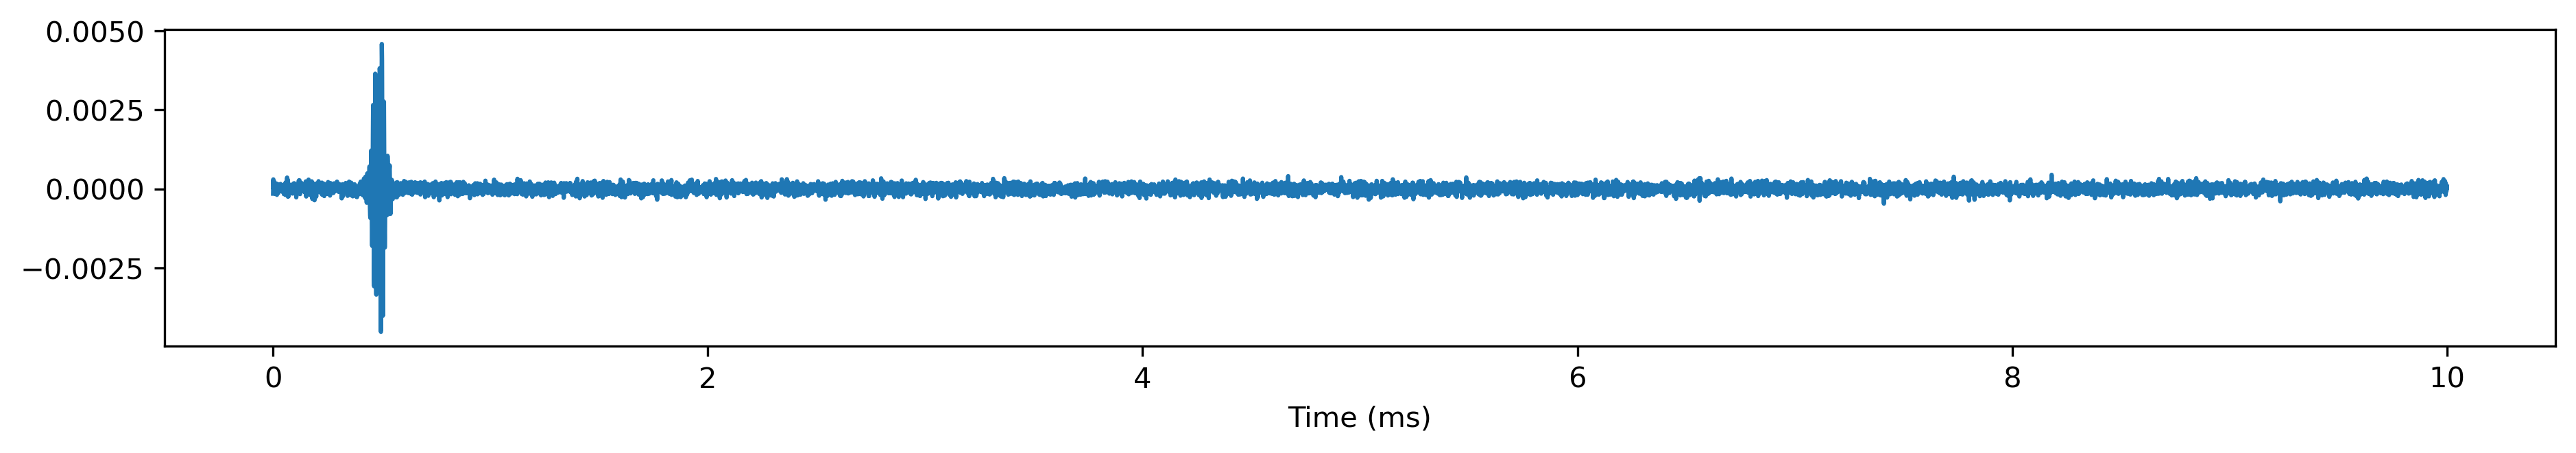

In [14]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal)/fs, len(signal)), signal)
print(f"Reference mean frequency: {MNF_1[0]} Hz")

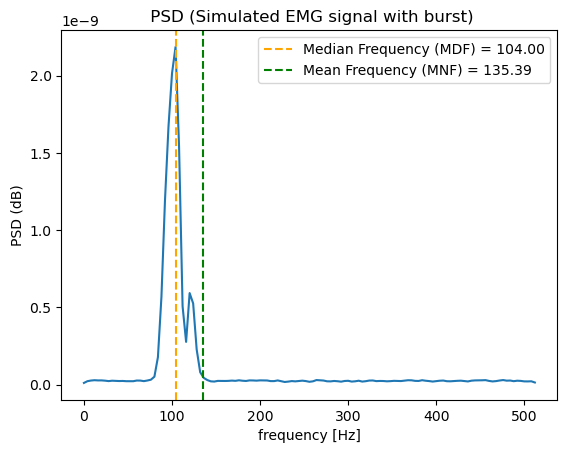

In [15]:
psd_welch, f_welch = superlet.compute_psd_welch(signal, fs, plot=True, muscle='Simulated EMG signal with burst')

In [16]:
# np.savetxt("/Users/neuralrehabilitationgroup/Desktop/señal_pocha.csv", signal, delimiter=",")


We first apply regular wavelet transforms to the signal, with wavelets of 3, 16 and 33 cycles long, respectively. Note that we specifically use the complex Morlet wavelet for both the wavelet and superlet transforms.

In [17]:
def calculate_mae(estimates, true_value):
    errors = np.abs(np.array(estimates) - true_value)
    mae = np.mean(errors)
    std_error = np.std(errors)
    return mae, std_error

In [18]:
freqs = jnp.linspace(0,300,800) # Número de puntos del vector frecuencia

In [19]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/CWT_parkison/superlets_package/superlets.py'>

## WAVELET PARAMETERS = 3, 16, 33, 55, 60, 115 cycles

In [20]:
plot_2 = True

In [21]:
offset = 0 # Para que la figura del instant mean frequency sea más mona
offset_burst = 20

NameError: name 'burst_start_1' is not defined

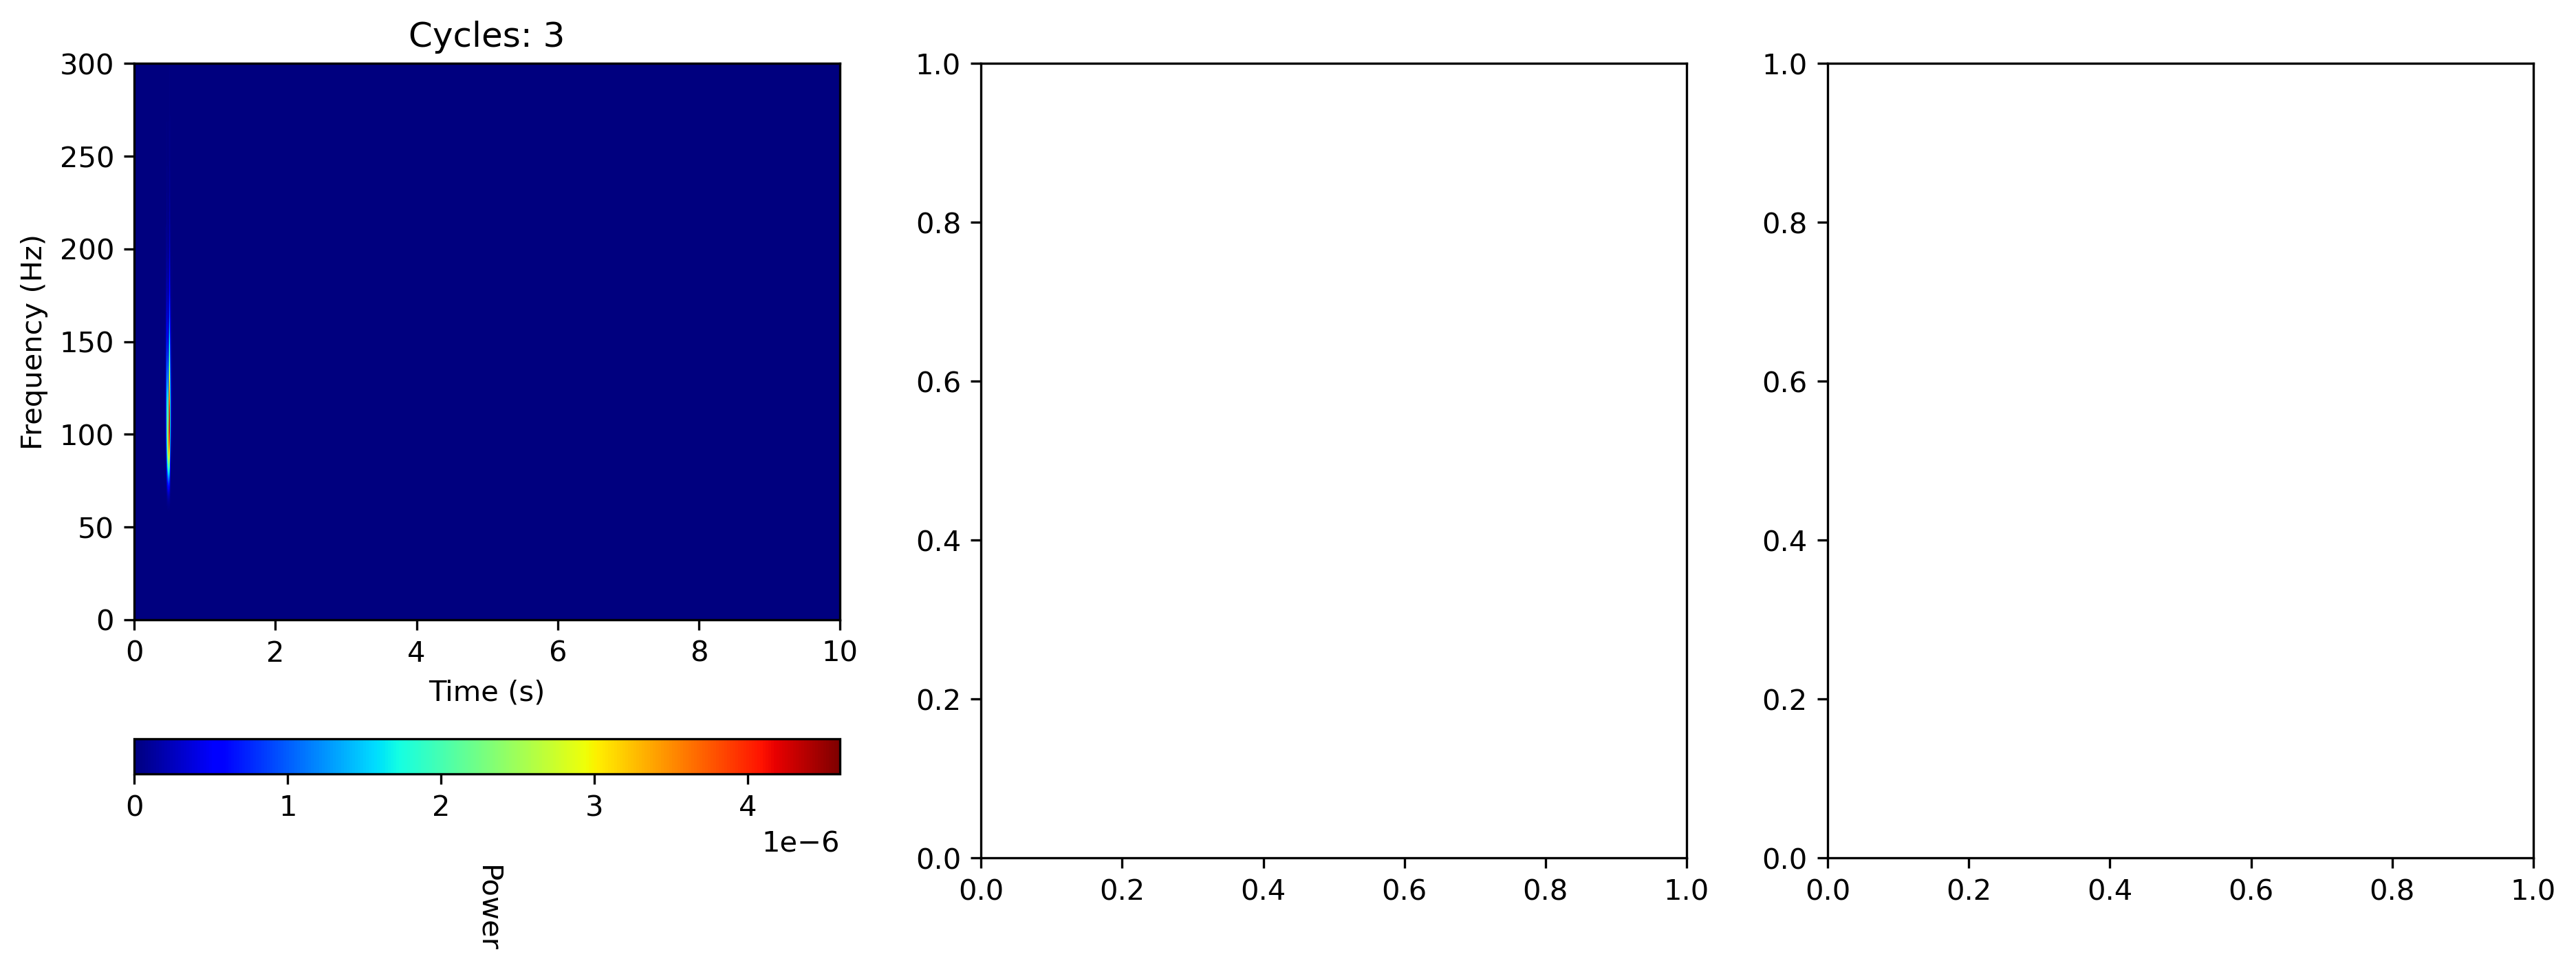

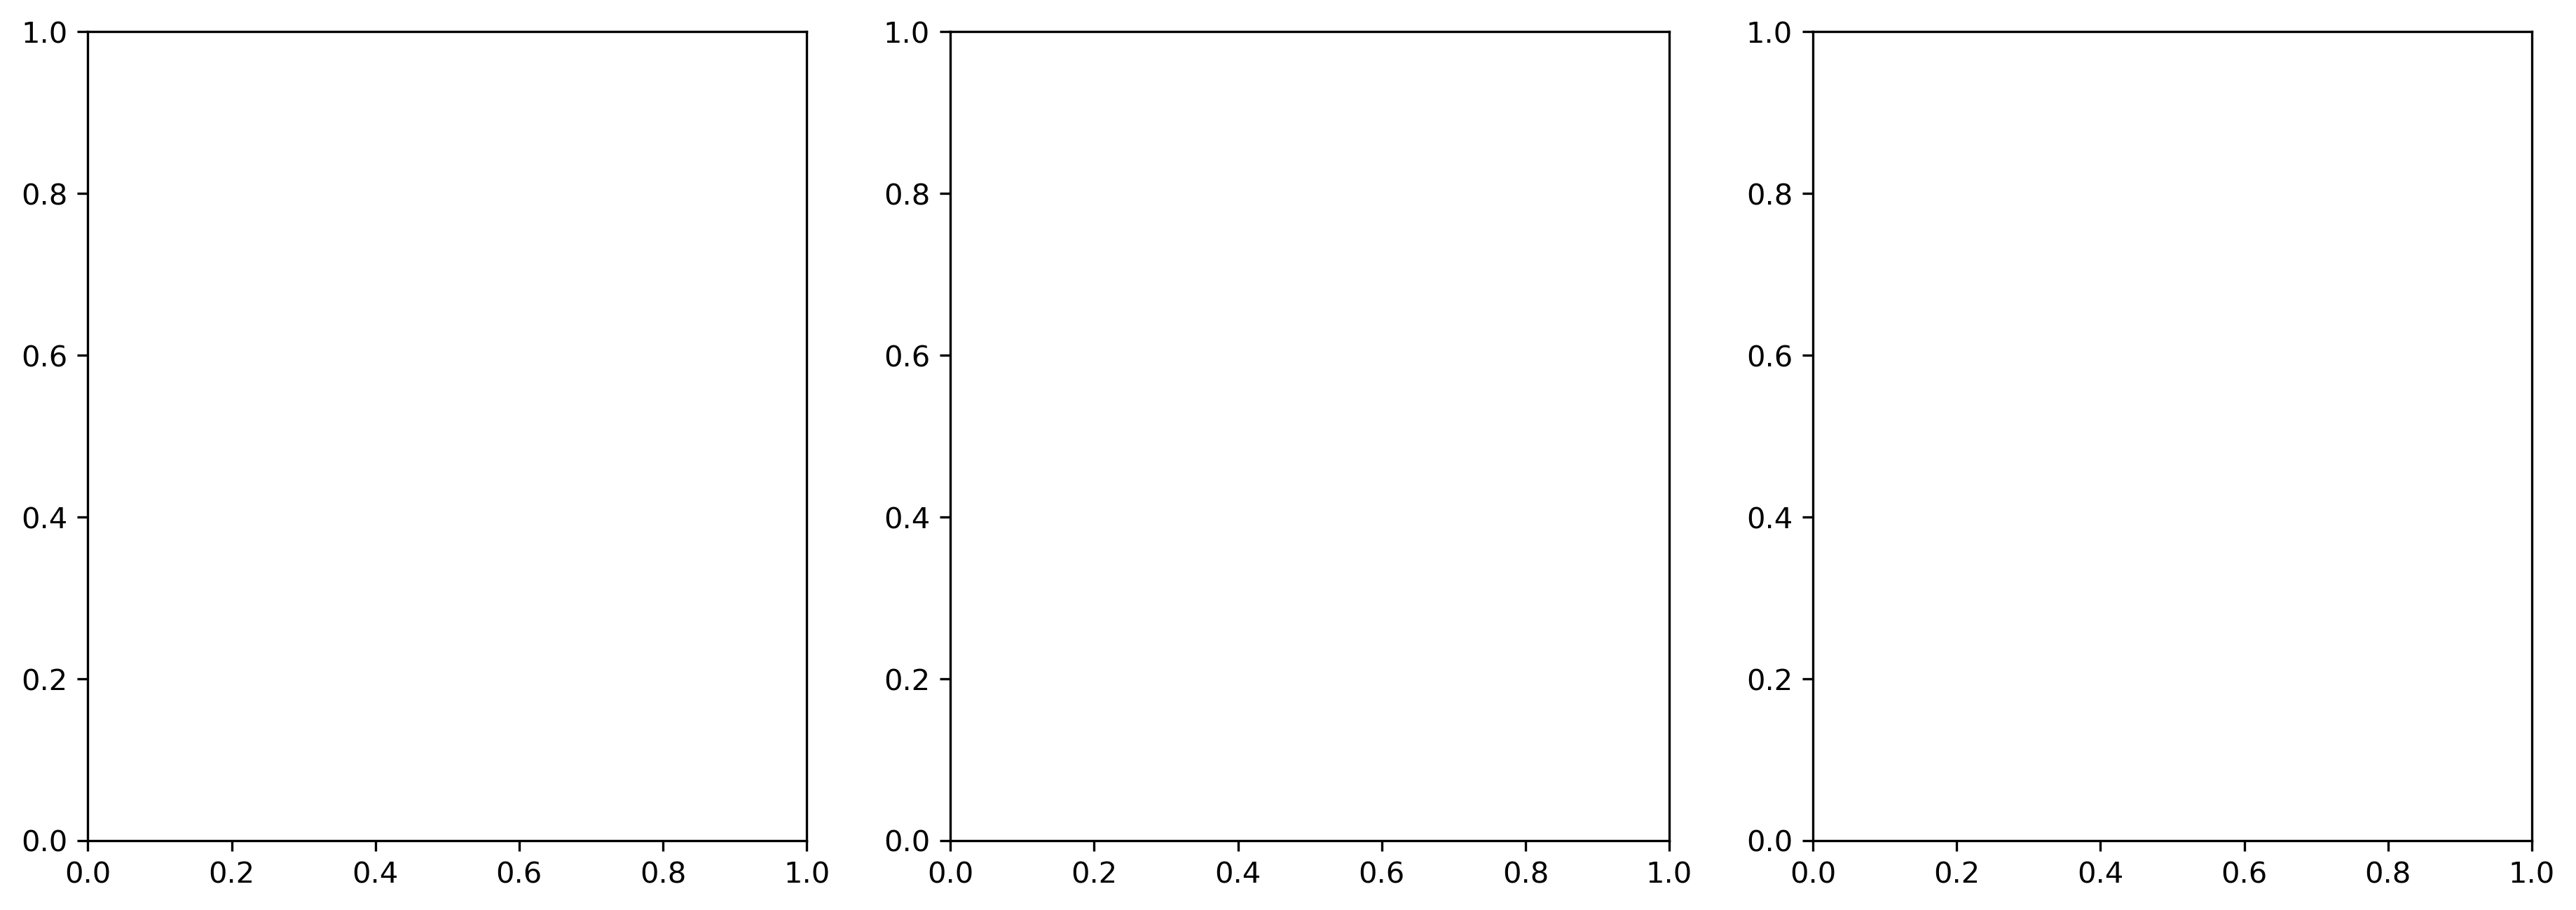

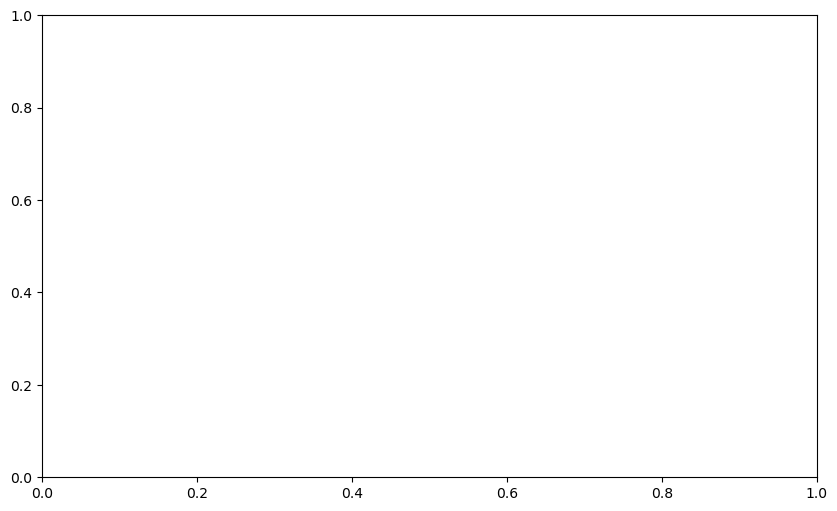

In [22]:
if plot_2:
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
    # Definir límites de color para que sean iguales en todos los subplots
    fig_2, ax_2 = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

params_wavelet = [3, 16, 33]

mae_wavelet = []
std_wavelet = []
times_wavelet = []

total_scalogram_wavelet = []
res_wavelet = []

for i, c in enumerate(params_wavelet):
    start_time = time.time()
    [wv, scalogram] = superlet.wavelet_transform(signal, freqs, c, fs)  
    
    if plot_2:
        im = ax[i].imshow(jnp.abs(scalogram)**2, aspect='auto', cmap="jet", interpolation="none", origin="lower", extent=[0, len(signal)/fs, freqs[0], freqs[-1]]) #, vmin=vmin, vmax=vmax)
        end_time = time.time()
        times_wavelet.append(end_time - start_time)
        ax[i].set_title(f"Cycles: {c}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")
        
        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=270, labelpad=15)  # Etiqueta de la colorbar
    
    #mean_freq = sum(power.*frequencies)/sum(power)
    #instant_mean.append(meanfreq(scalogram[:, col], freqs) for col in range(scalogram.shape[1]))
    
    scalogram_2 = np.abs(scalogram)**2    
    
    if np.any(np.isnan(jnp.abs(scalogram)**2)) or np.any(np.isinf(jnp.abs(scalogram)**2)):
        scalogram_2 = np.nan_to_num(jnp.abs(scalogram)**2)

    total_scalogram_wavelet.append(scalogram_2)  
    instant_mean_freq_total = []
    
    instant_mean_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)    
        
    initial_imnf = instant_mean_freq[:round(burst_start_1 * fs) - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)
    
    instant_mean_freq_burst = instant_mean_freq[round(burst_start_1 * fs):round((burst_start_1 + burst_duration_1)*fs)]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(instant_mean_freq_burst)-offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)
    # plt.figure()
    # plt.plot(instant_mean_freq_burst)
     
    final_imnf = instant_mean_freq[round((burst_start_1 + burst_duration_1)*fs) + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)

    # Create time (each column is a time instant)
    tiempo = np.arange(len(instant_mean_freq_total)) / fs
    
    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total, label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')
        
        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)
        
        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {c})")
    
    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_wavelet.append(mae)
    std_wavelet.append(std)

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
    
    plt.tight_layout()
res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, tiempo, freqs, params_wavelet)

In [67]:
mae_wavelet

[26.45639417887282, 16.015824332968208, 21.872469628082435]

#### Mayor número de ciclos

TypeError: slice indices must be integers or None or have an __index__ method

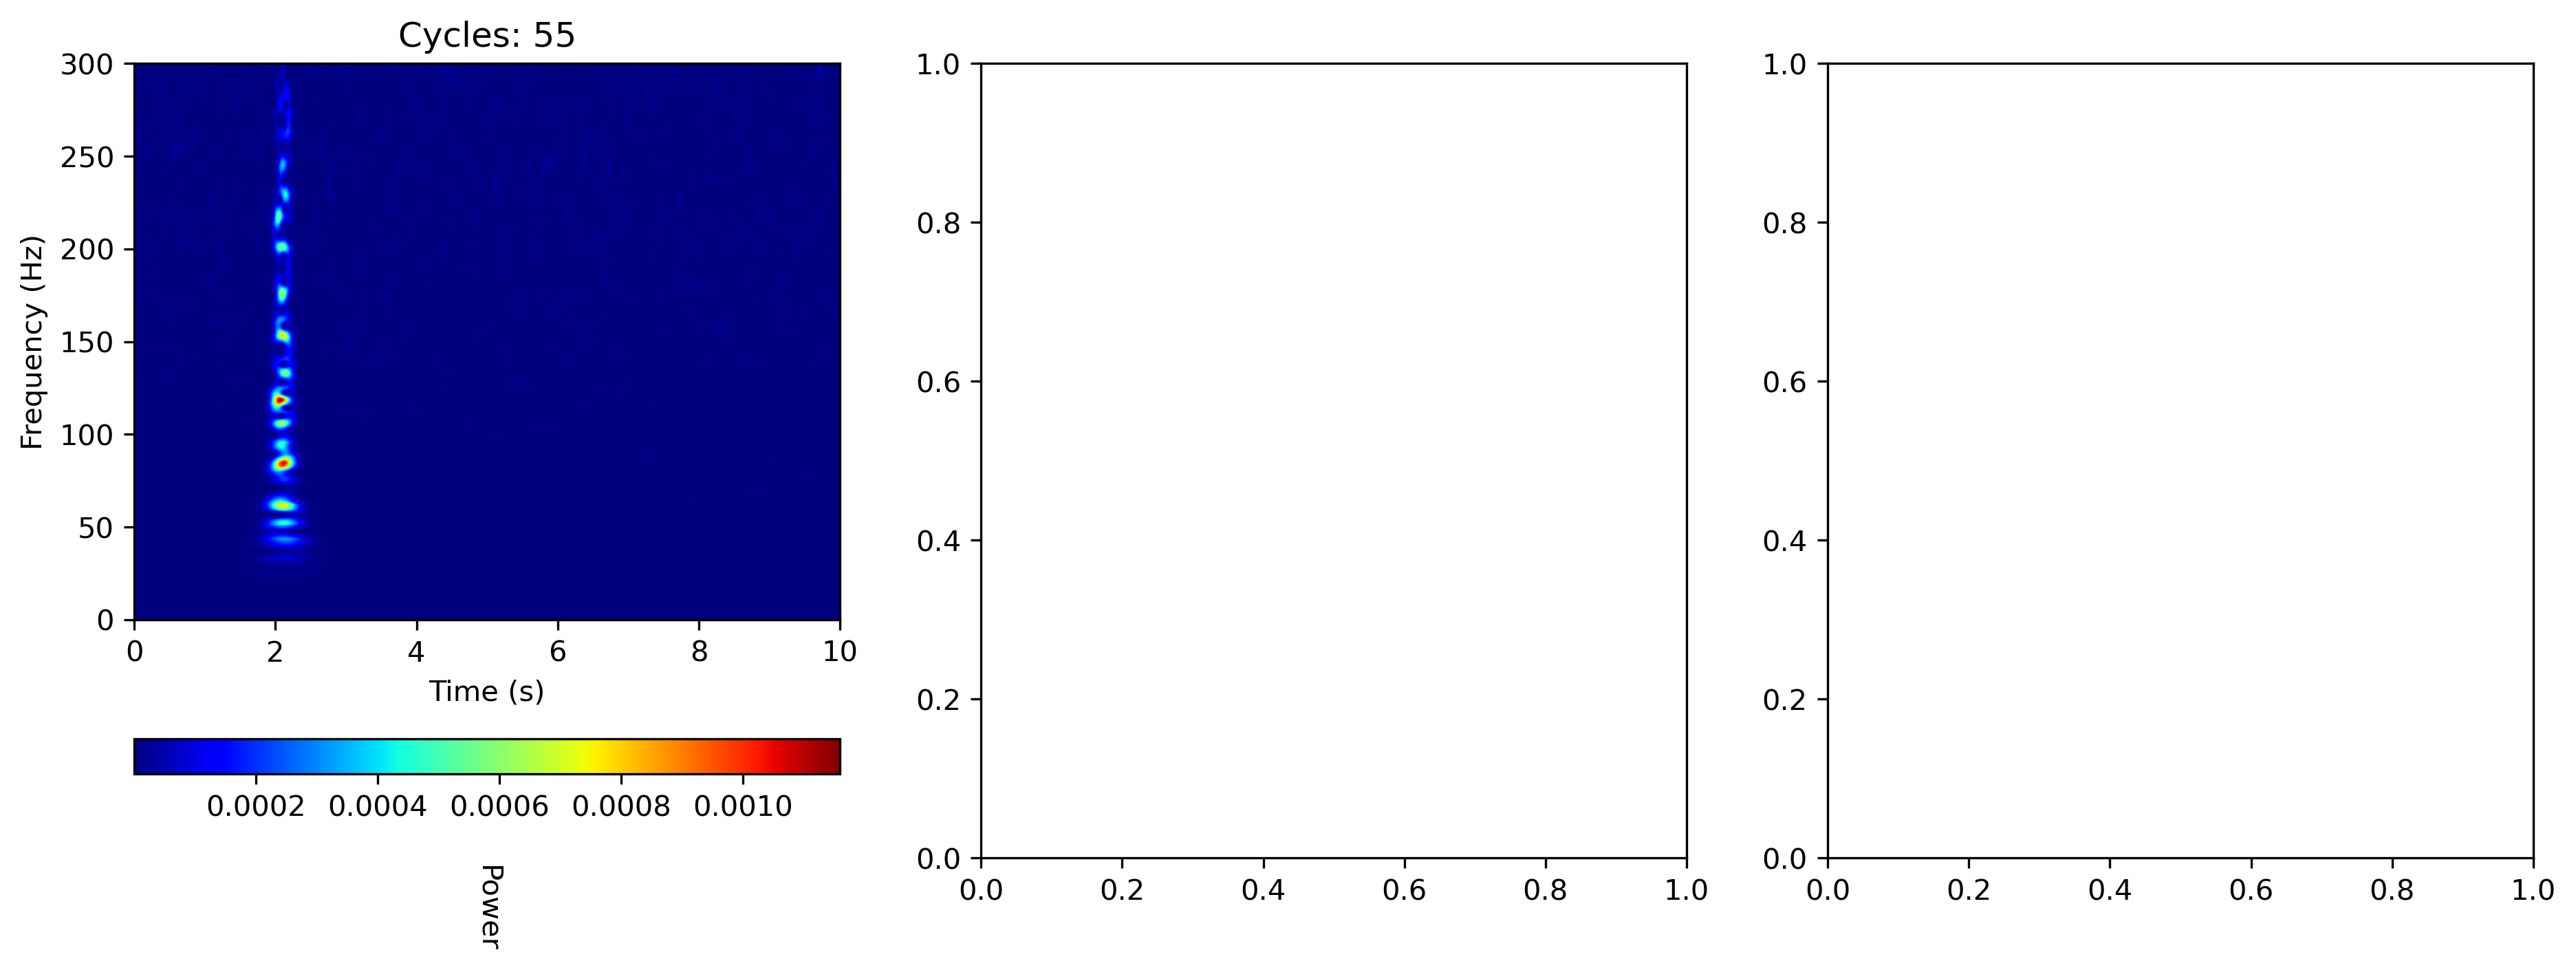

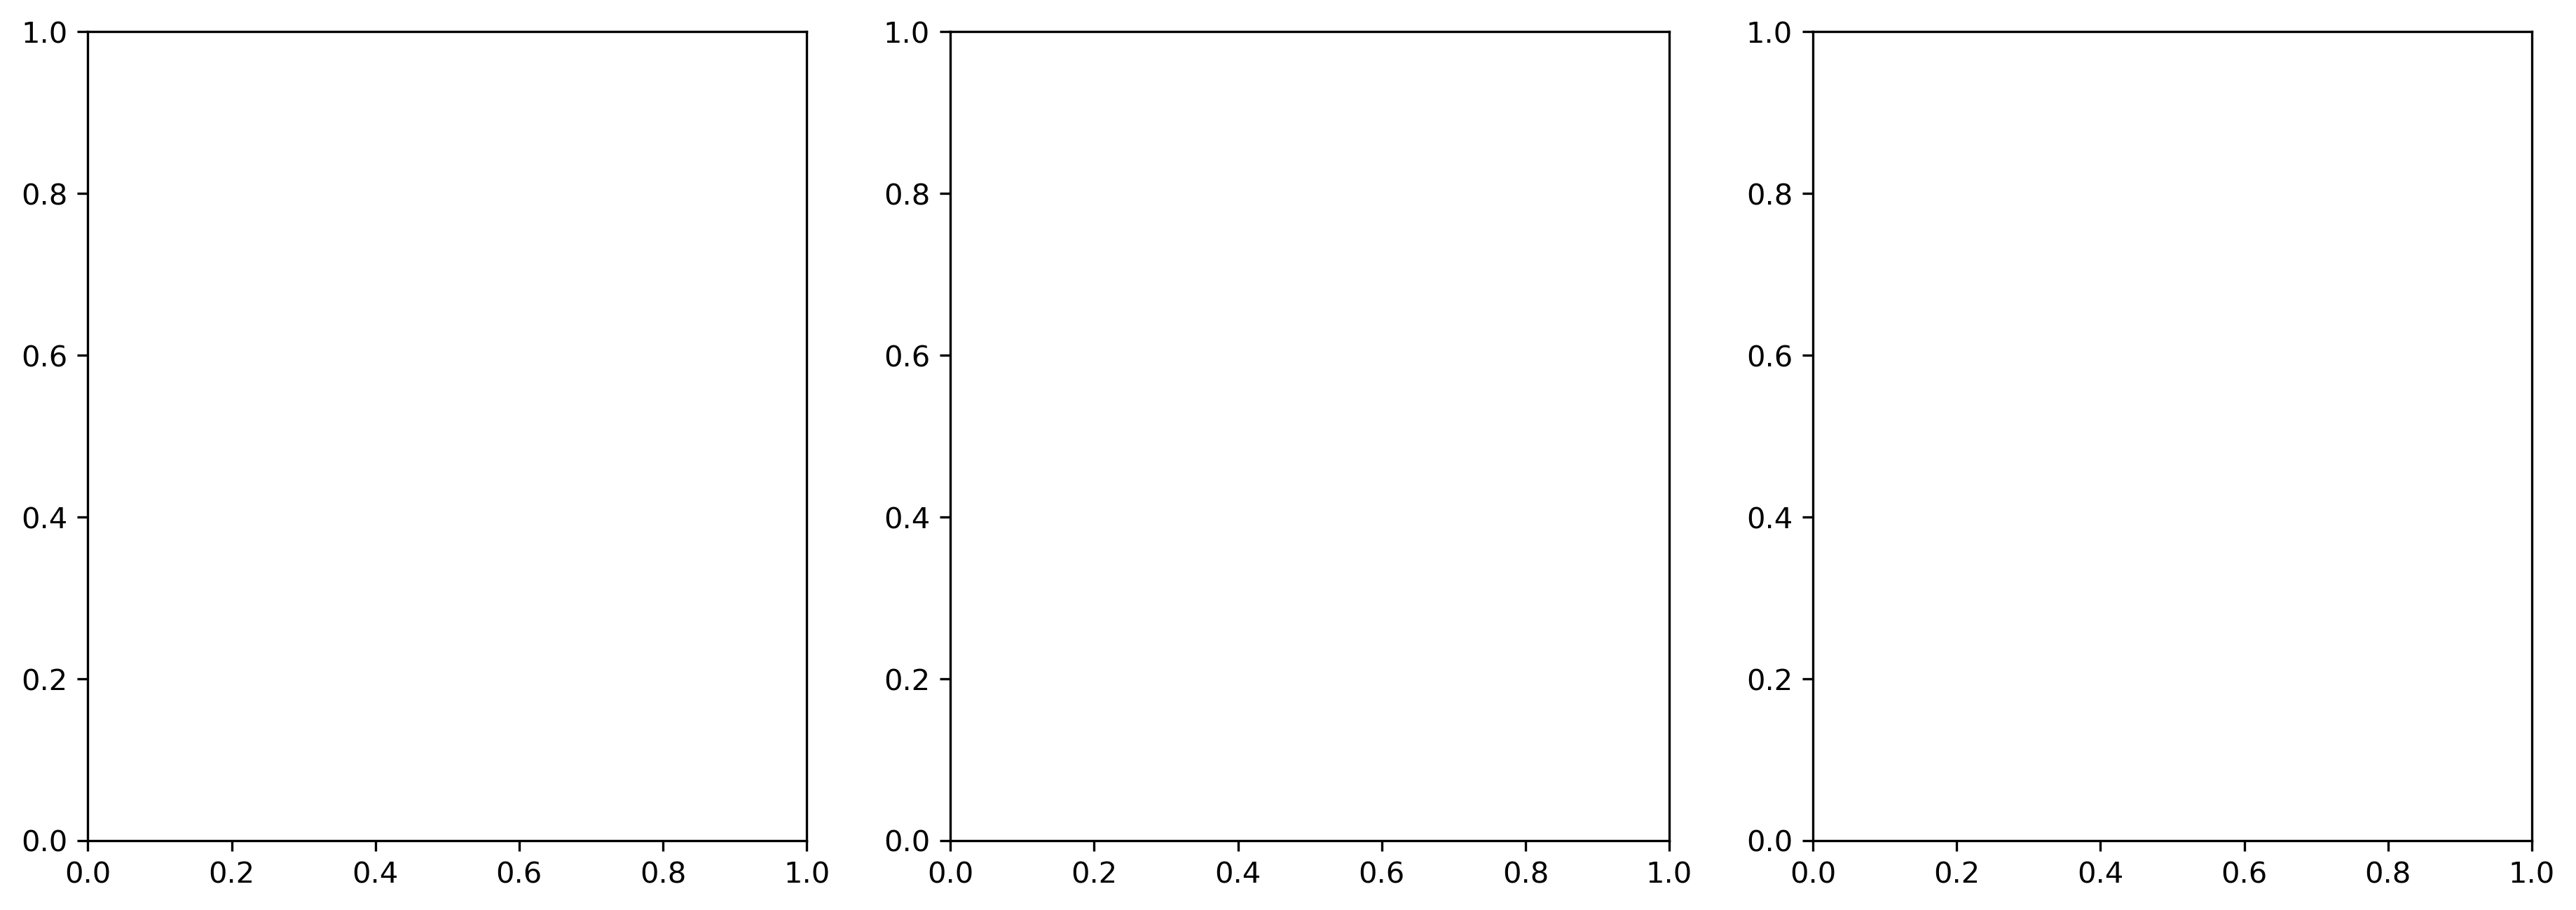

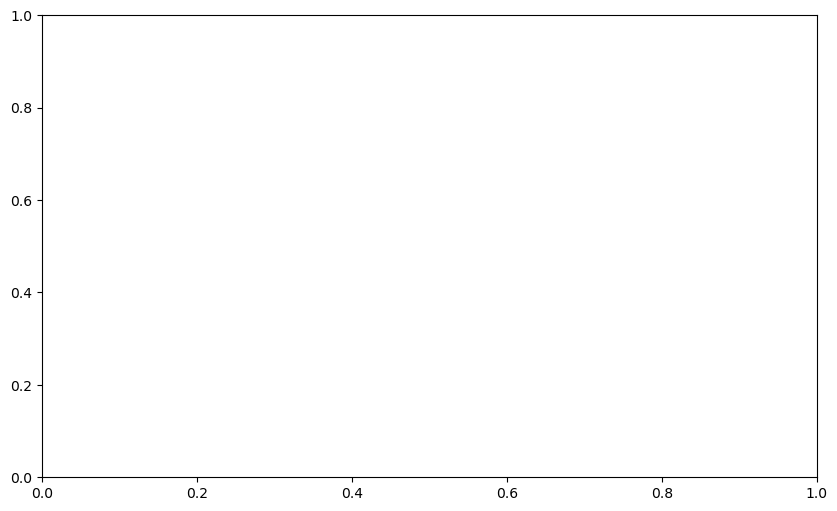

In [68]:
if plot_2:
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
    # Definir límites de color para que sean iguales en todos los subplots
    fig_2, ax_2 = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

offset = 0
offset_burst = 50

for i, c in enumerate([55, 60, 115]):
    start_time = time.time()
    [wv, scalogram] = superlet.wavelet_transform(signal, freqs, c, fs)
    end_time = time.time()
    times_wavelet.append(end_time - start_time)
    if plot_2:
        im = ax[i].imshow(jnp.abs(scalogram)**2, aspect='auto', cmap="jet", interpolation="none", origin="lower", extent=[0, len(signal)/fs, freqs[0], freqs[-1]]) #, vmin=vmin, vmax=vmax)
        ax[i].set_title(f"Cycles: {c}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")
    
        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=270, labelpad=15)  # Etiqueta de la colorbar
    
    #mean_freq = sum(power.*frequencies)/sum(power)
    #instant_mean.append(meanfreq(scalogram[:, col], freqs) for col in range(scalogram.shape[1]))
    
    scalogram_2 = np.abs(scalogram)**2    
    
    if np.any(np.isnan(jnp.abs(scalogram)**2)) or np.any(np.isinf(jnp.abs(scalogram)**2)):
        scalogram_2 = np.nan_to_num(jnp.abs(scalogram)**2)
        
    total_scalogram_wavelet.append(scalogram_2)
 
    instant_mean_freq_total = []
    
    instant_mean_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)    
        
    initial_imnf = instant_mean_freq[:burst_start_1 * fs - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)
    
    instant_mean_freq_burst = instant_mean_freq[burst_start_1 * fs:(burst_start_1 + burst_duration_1)*fs]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(instant_mean_freq_burst)-offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)
    # plt.figure()
    # plt.plot(instant_mean_freq_burst)
     
    final_imnf = instant_mean_freq[(burst_start_1 + burst_duration_1)*fs + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)

    # Create time (each column is a time instant)
    tiempo = np.arange(len(instant_mean_freq_total)) / fs
    
    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total, label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')
        
        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)
        
        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {c})")
    
    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_wavelet.append(mae)
    std_wavelet.append(std)

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
    
    plt.tight_layout()
    
res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, tiempo, freqs)

In [23]:
# import matplotlib.pyplot as plt
# 
# # Supongamos que la frecuencia central de cada wavelet varía en un rango de frecuencias
# frequencies = jnp.linspace(1, 50, 141)  # Por ejemplo, de 1 a 50 Hz con 141 frecuencias
# 
# # Define un vector de tiempo
# t = jnp.linspace(-1, 1, 2048)  # Tiempo con 2048 puntos
# 
# # Grafica la wavelet para una frecuencia específica (por ejemplo, la frecuencia central de 20 Hz)
# freq_idx = 70  # Índice de frecuencia alrededor de la mitad del rango
# plt.plot(t, jnp.real(wv[freq_idx]), label=f'Wavelet en {frequencies[freq_idx]:.2f} Hz')
# plt.xlabel("Tiempo (s)")
# plt.ylabel("Amplitud")
# plt.title("Parte Real de la Wavelet Morlet a una Frecuencia Específica")
# plt.xlim(-1.3, 1.3)
# plt.legend()
# plt.show()



In [24]:
# plt.imshow(jnp.abs(wv), aspect='auto', extent=[-1, 1, frequencies[-1], frequencies[0]], cmap='viridis')
# plt.colorbar(label="Amplitud")
# plt.xlabel("Tiempo (s)")
# plt.ylabel("Frecuencia (Hz)")
# plt.title("Representación Tiempo-Frecuencia de la Wavelet")
# plt.show()


There's a tradeoff above; using a low number of cycles results in high temporal resolution, but poor frequency resolution (the activations are "smeared" on the frequency dimension). On the other hand, a high number of cycles results in high frequency resolution, but poor temporal resolution. 

There are fundamental limits to how precise we can be on *both* aspects without making a tradeoff on either (the Gabor limit), but the standard wavelet transform isn't on that optimal boundary. Superlets improve resolution on both (time *and* frequency) by taking the geometric mean of wavelet transforms of different cycle lengths, more tightly approaching the Gabor limit.

In [25]:
mae_wavelet

[34.61507868320756,
 30.04354317097569,
 31.383080562788933,
 31.481929439866917,
 31.704647170896873,
 32.55592498879227]

In [42]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/CWT_parkison/superlets_package/superlets.py'>

## PARÁMETROS SUPERLET: base_cycle, min_order, max_order = [3, 5, 1, 1, 1, 1], [1, 1, 5, 10, 20, 30], [30, 30, 40, 100, 100, 200]

100.17475
100.23399
106.519394


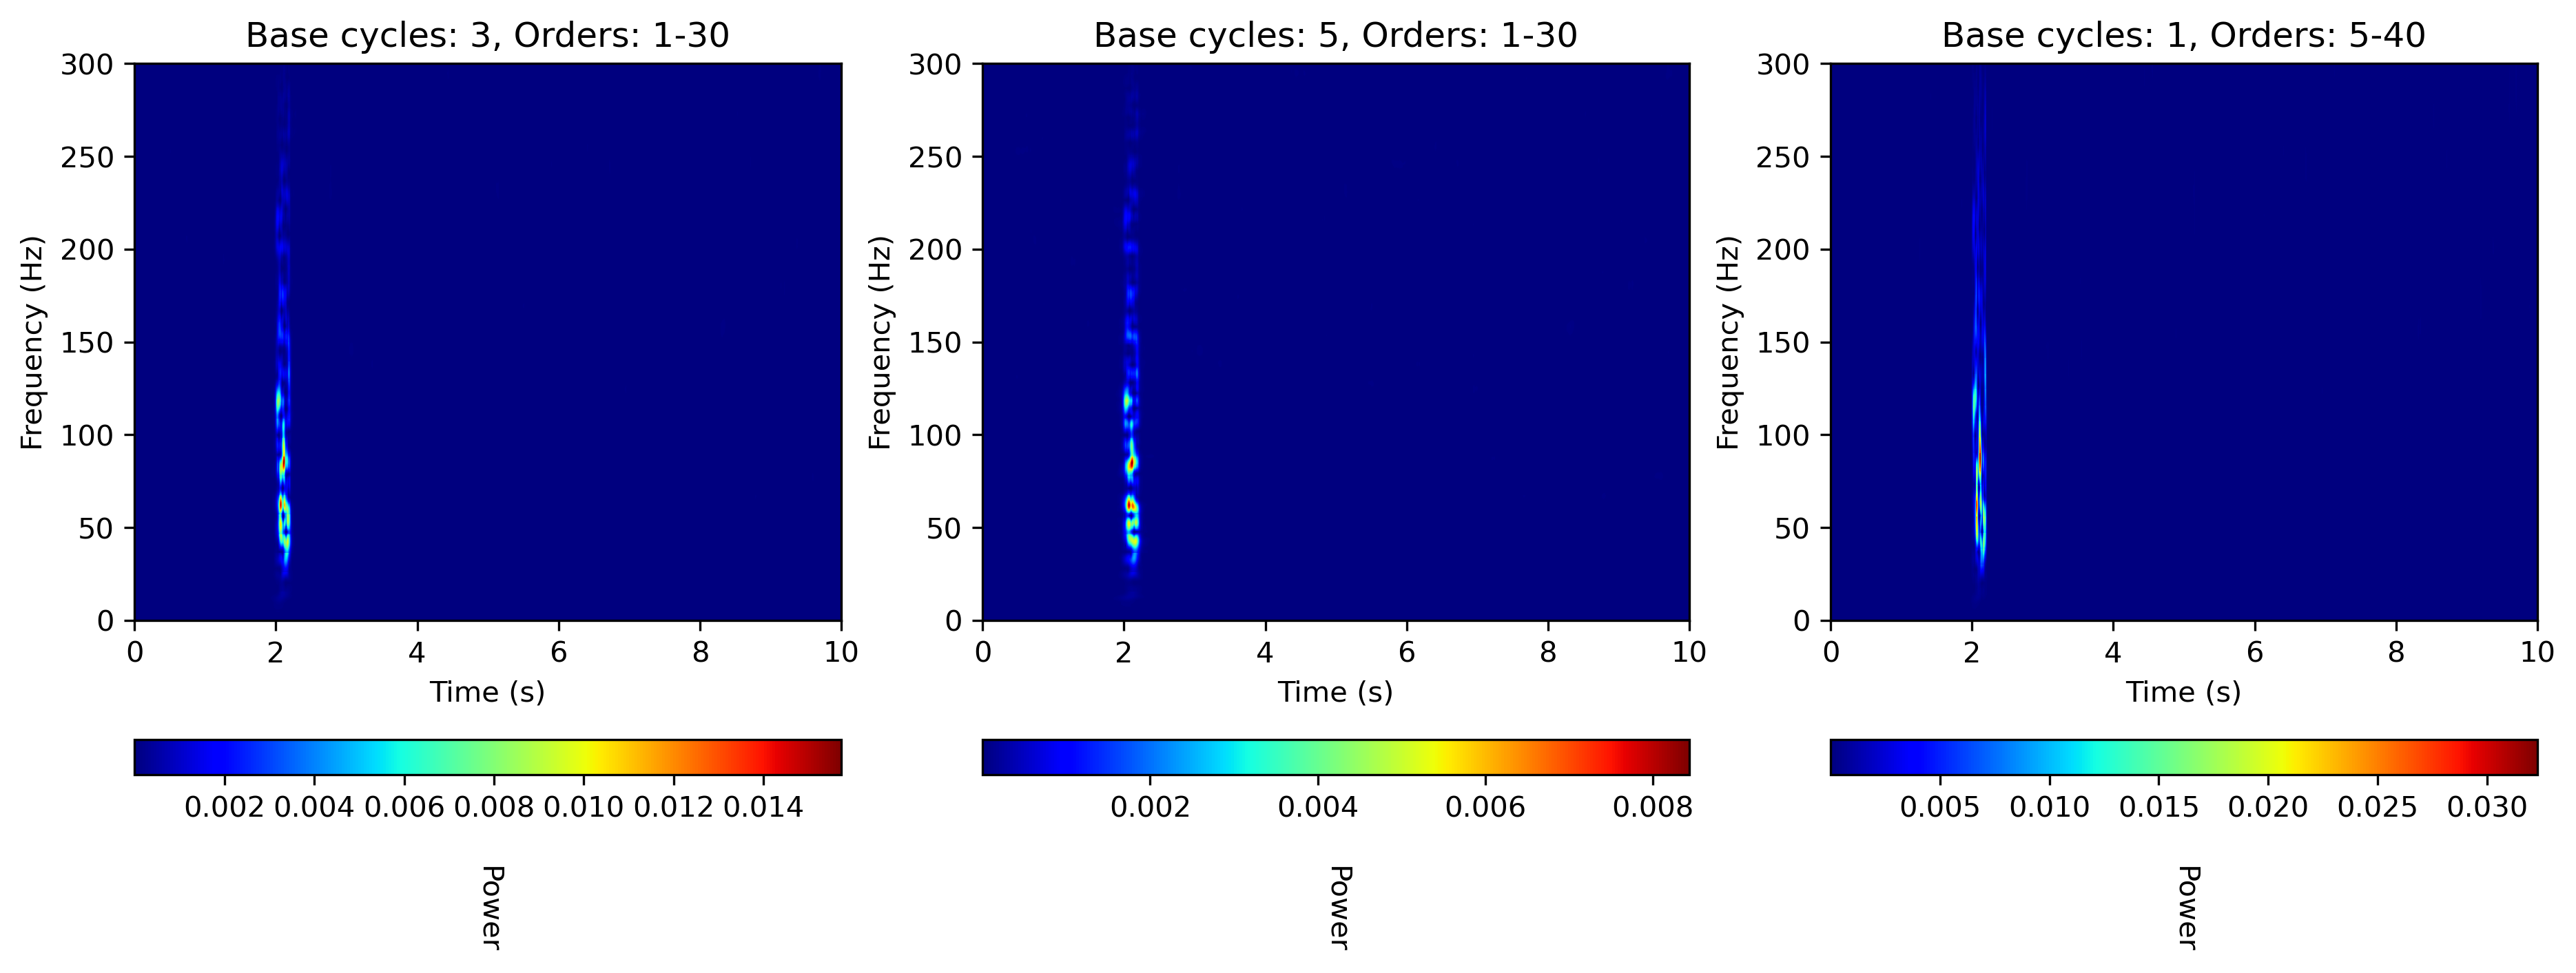

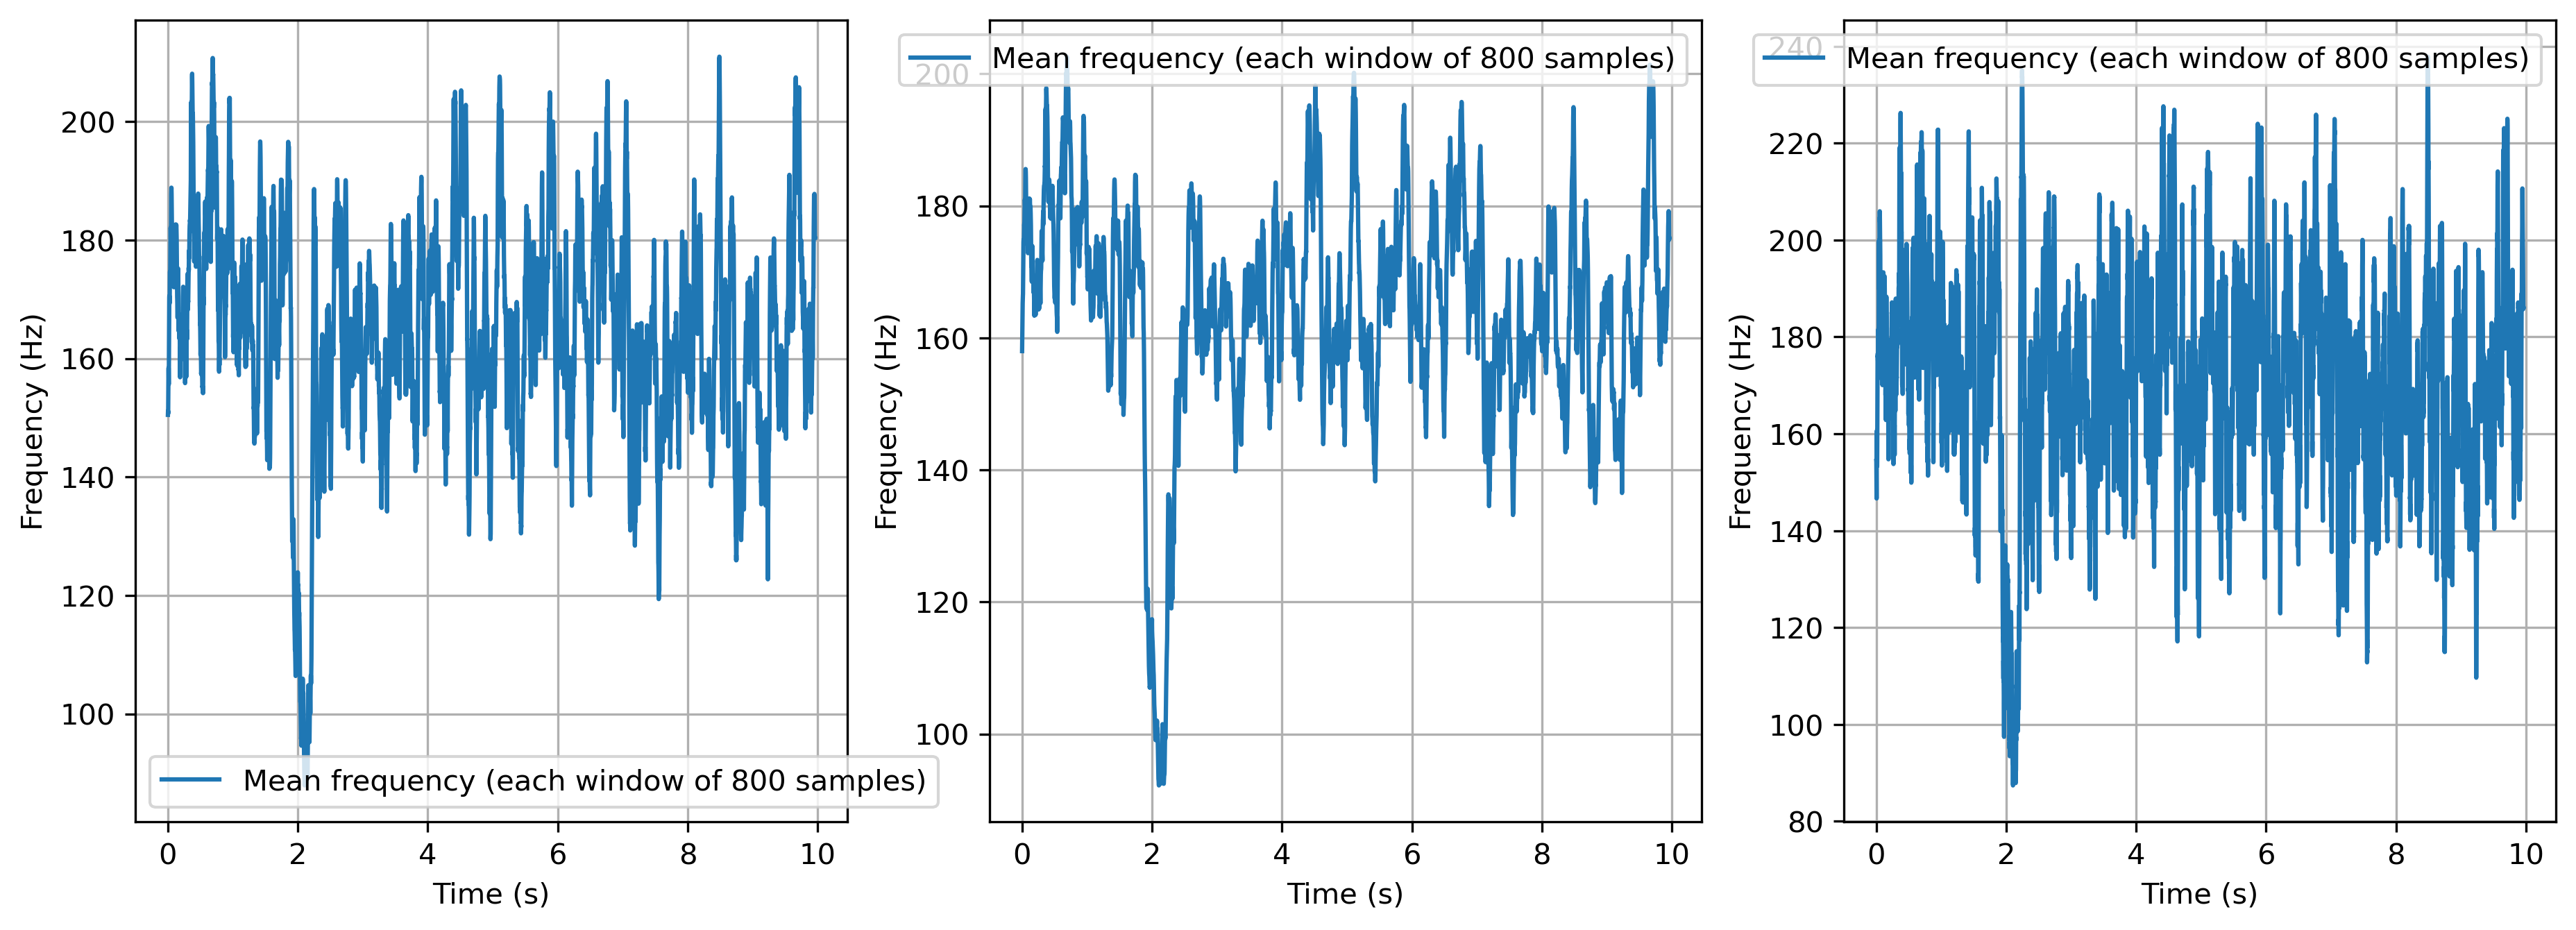

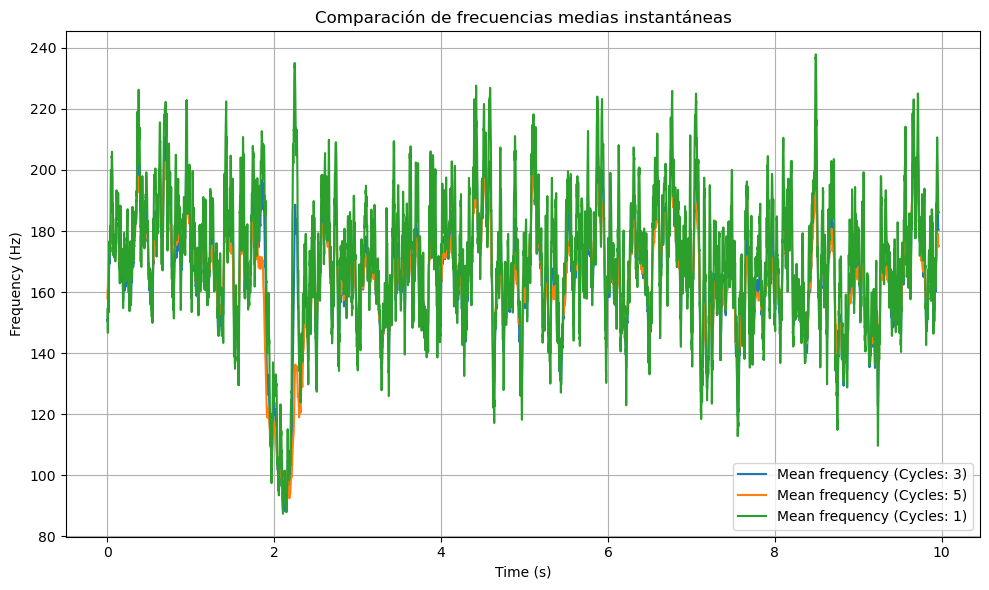

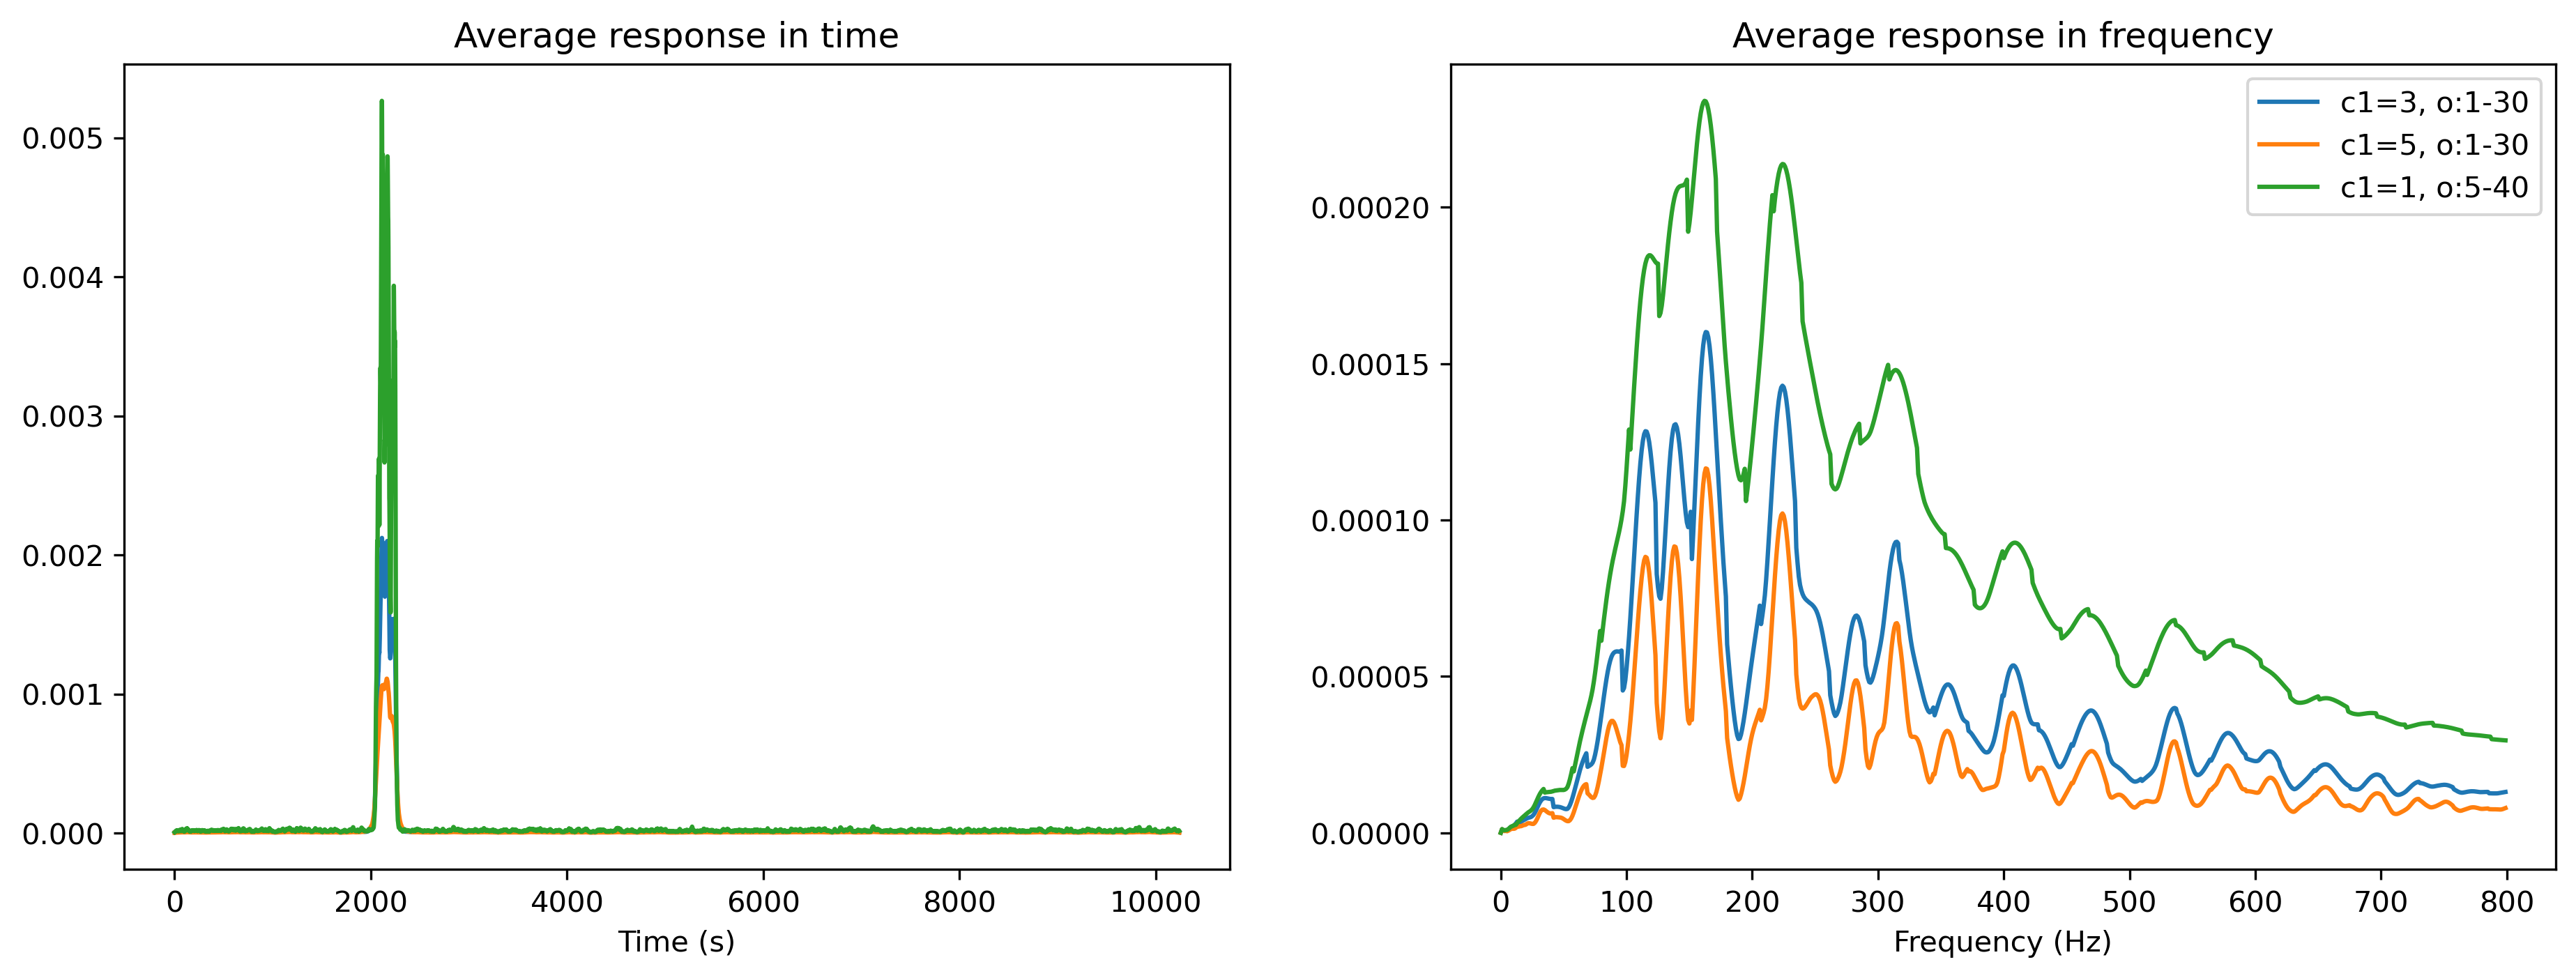

In [86]:
if plot_2:
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
    fig_2, ax_2 = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_superlet = []
std_superlet = []
times_superlet = []

offset = 0
offset_burst = 20

total_scalogram_superlet = []

#enumerate(zip([3,5,1], [1,1,5], [30,30,40])):
#enumerate(zip([1,1,1], [10,20,30], [100,100,200])):
for (i, (base_cycle, min_order, max_order)) in enumerate(zip([3,5,1], [1,1,5], [30,30,40])):
    start_time = time.time()
    wv, scalogram = superlet.adaptive_superlet_transform(signal, freqs, sampling_freq=fs, 
                                        base_cycle=base_cycle, min_order=min_order, max_order=max_order, mode="mul")
    end_time = time.time()
    times_superlet.append(end_time - start_time)
    if plot_2:
        im = ax[i].imshow(jnp.abs(scalogram)**2, aspect='auto', cmap="jet", interpolation="none", origin="lower", extent=[0, len(signal)/fs, freqs[0], freqs[-1]])
        ax[i].set_title(f"Base cycles: {base_cycle}, Orders: {min_order}-{max_order}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")
        
        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=270, labelpad=15)  # Etiqueta de la colorbar
    
    scalogram_2 = np.abs(scalogram)**2    
    
    if np.any(np.isnan(jnp.abs(scalogram)**2)) or np.any(np.isinf(jnp.abs(scalogram)**2)):
        scalogram_2 = np.nan_to_num(jnp.abs(scalogram)**2)
 
    total_scalogram_superlet.append(scalogram_2)
    #scalogram_2 = scalogram_2 * freqs[:, np.newaxis]  
    
    instant_mean_freq_total = []
    
    instant_mean_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)   
        
    initial_imnf = instant_mean_freq[:round(burst_start_1 * fs) - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)
    
    instant_mean_freq_burst = instant_mean_freq[round(burst_start_1 * fs):round((burst_start_1 + burst_duration_1)*fs)]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:round(len(instant_mean_freq_burst))-offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)
    # plt.figure()
    # plt.plot(instant_mean_freq_burst)
     
    final_imnf = instant_mean_freq[round((burst_start_1 + burst_duration_1)*fs) + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)

    # Create time (each column is a time instant)
    tiempo = np.arange(len(instant_mean_freq_total)) / fs
    
    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total, label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')
        
        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)
        
        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {base_cycle})")
        
    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_superlet.append(mae)
    std_superlet.append(std)

if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
    
    plt.tight_layout()
res_superlet = superlet.compute_avg_response_resolution(total_scalogram_superlet, tiempo, freqs, ['c1=3, o:1-30', 'c1=5, o:1-30', 'c1=1, o:5-40'])

In [87]:
mae_superlet

[13.473368200473727, 11.175575657427398, 13.191961881650714]

In [71]:
if plot_2:
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
    fig_2, ax_2 = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

#enumerate(zip([3,5,1], [1,1,5], [30,30,40])):
#enumerate(zip([1,1,1], [10,20,30], [100,100,200])):
for (i, (base_cycle, min_order, max_order)) in enumerate(zip([1,1,1], [10,20,30], [100,100,150])):
    start_time = time.time()
    wv, scalogram = superlet.adaptive_superlet_transform(signal, freqs, sampling_freq=fs, 
                                        base_cycle=base_cycle, min_order=min_order, max_order=max_order, mode="mul")
    
    end_time = time.time()
    times_superlet.append(end_time - start_time)
    
    if plot_2:
        im = ax[i].imshow(jnp.abs(scalogram)**2, aspect='auto', cmap="jet", interpolation="none", origin="lower", extent=[0, len(signal)/fs, freqs[0], freqs[-1]])
        ax[i].set_title(f"Base cycles: {base_cycle}, Orders: {min_order}-{max_order}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")
        
        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=270, labelpad=15)  # Etiqueta de la colorbar
    
    scalogram_2 = np.abs(scalogram)**2    
    
    if np.any(np.isnan(jnp.abs(scalogram)**2)) or np.any(np.isinf(jnp.abs(scalogram)**2)):
        scalogram_2 = np.nan_to_num(jnp.abs(scalogram)**2)
        
    total_scalogram_superlet.append(scalogram_2)
 
    instant_mean_freq_total = []
    
    instant_mean_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)    
        
    initial_imnf = instant_mean_freq[:burst_start_1 * fs - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)
    
    instant_mean_freq_burst = instant_mean_freq[burst_start_1 * fs:(burst_start_1 + burst_duration_1)*fs]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(instant_mean_freq_burst)-offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)
    # plt.figure()
    # plt.plot(instant_mean_freq_burst)
    
    final_imnf = instant_mean_freq[(burst_start_1 + burst_duration_1)*fs + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)

    # Create time (each column is a time instant)
    tiempo = np.arange(len(instant_mean_freq_total)) / fs
    
    if plot_2:
    
        ax_2[i].plot(tiempo, instant_mean_freq_total, label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')
        
        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)
        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {base_cycle})")
    
    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_superlet.append(mae)
    std_superlet.append(std)


if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
    
    plt.tight_layout()
    
res_superlet = superlet.compute_avg_response_resolution(total_scalogram_superlet, tiempo, freqs)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f9d011b4820> (for post_execute):



KeyboardInterrupt



In [73]:
mae_superlet

[13.473368200473727, 11.175575657427398, 13.191961881650714]

## STFT PARAMETERS (window = duration/cycles) = 38, 200, 413, 550, 600, 824 ms

In [88]:
offset_burst = 0
offset = 0

113.65553692670461
104.5874463957431
102.97908488374333


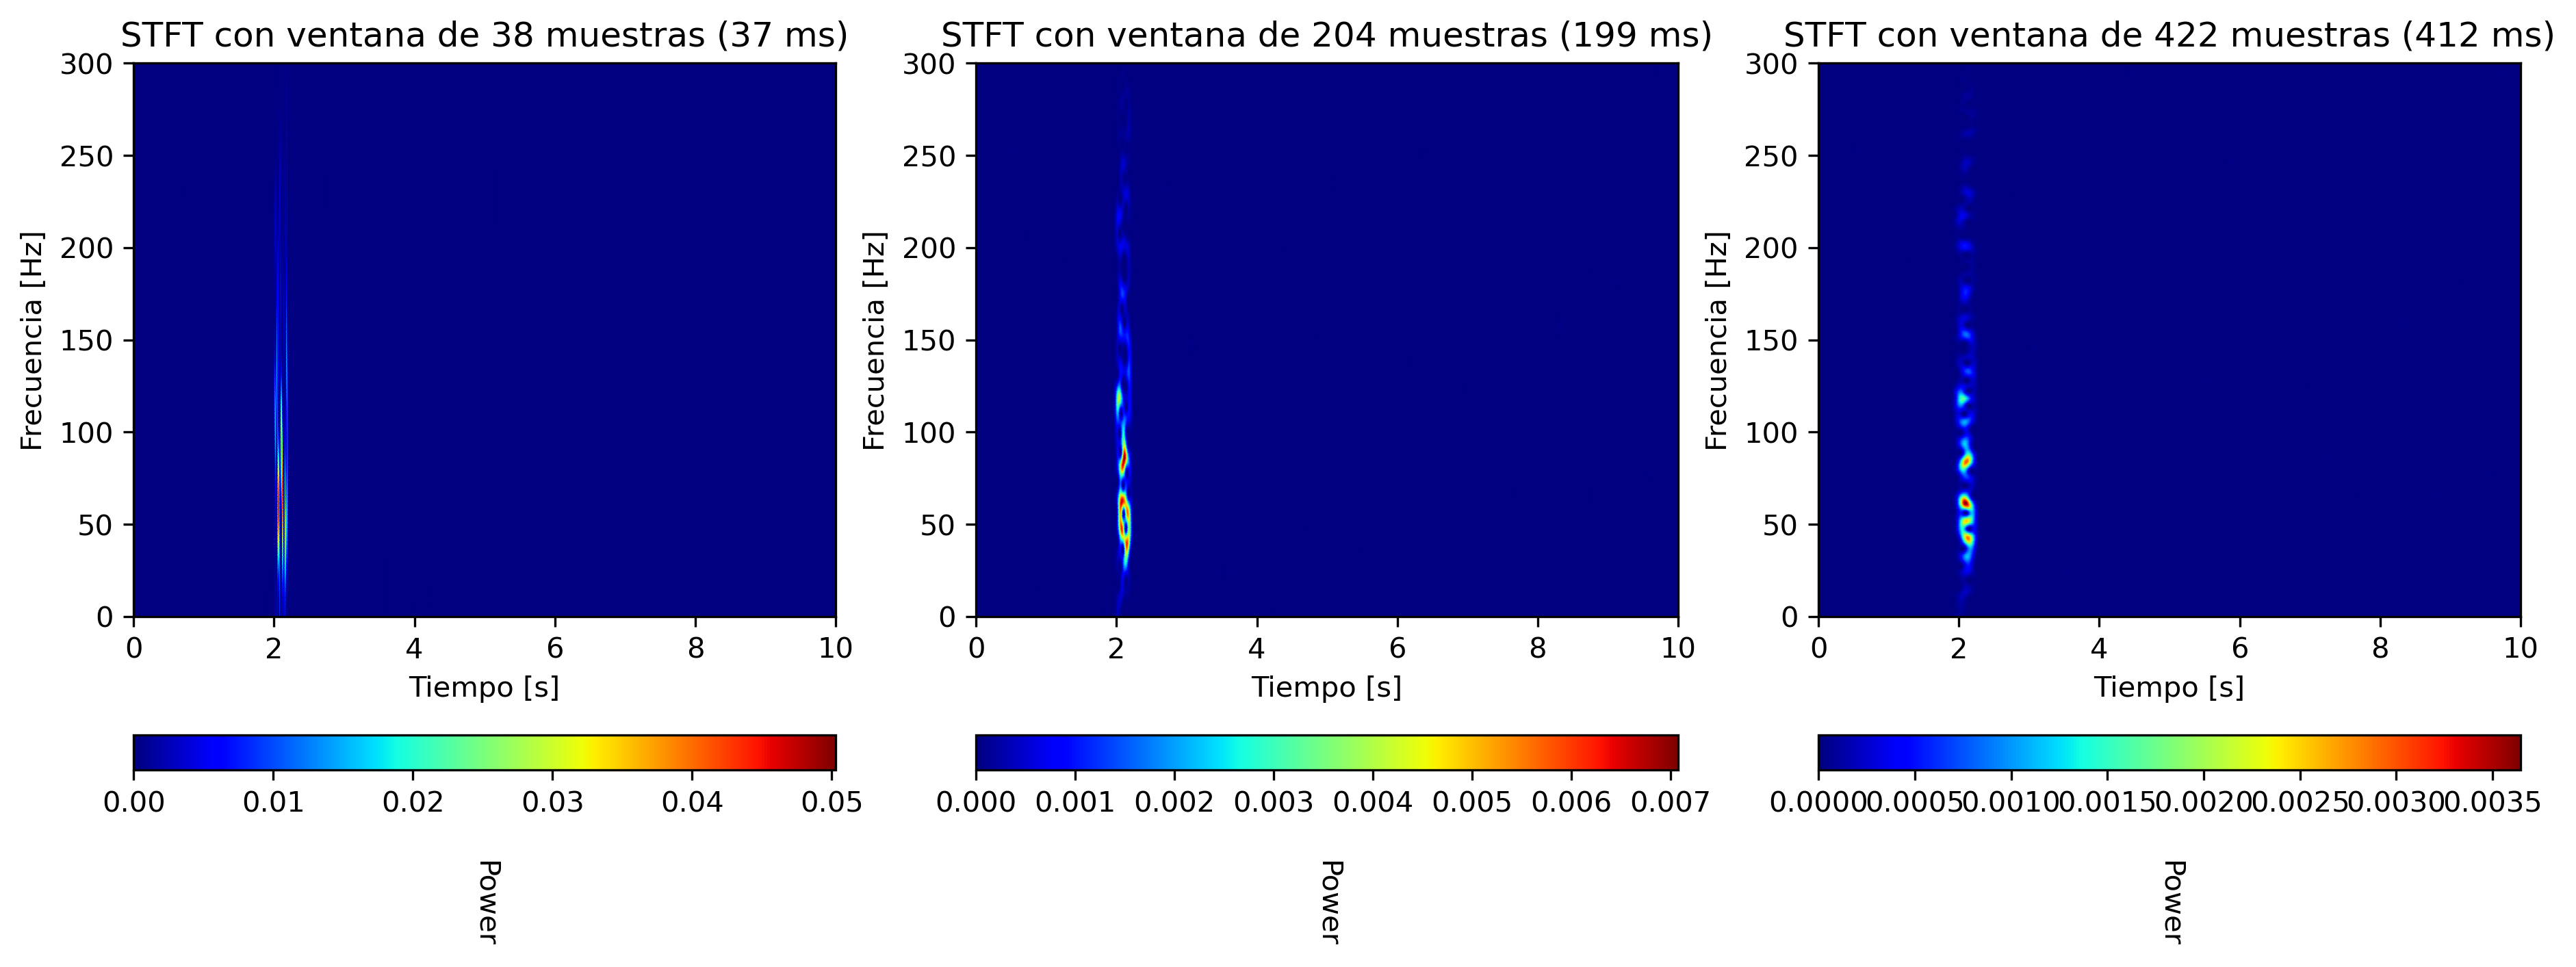

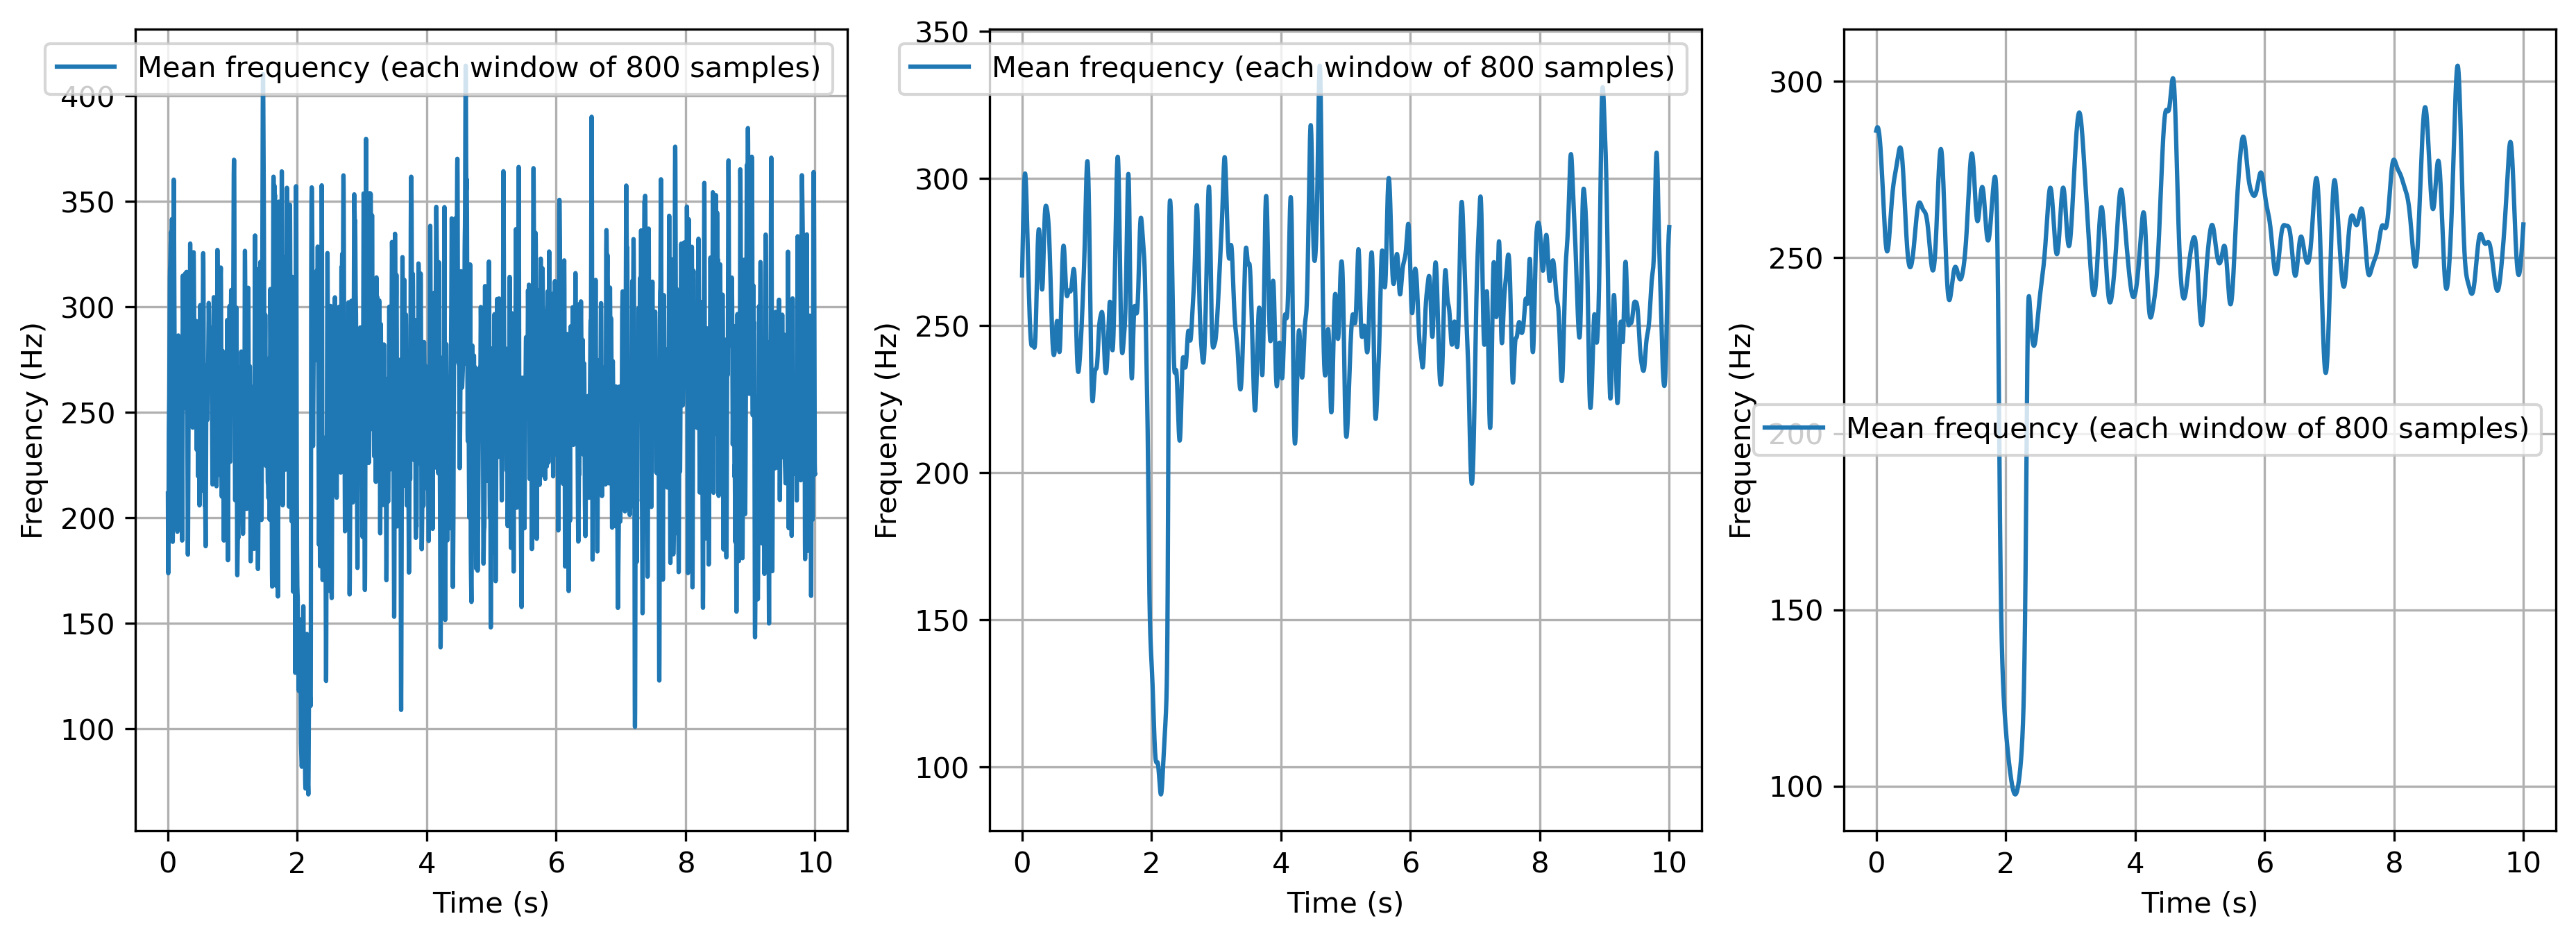

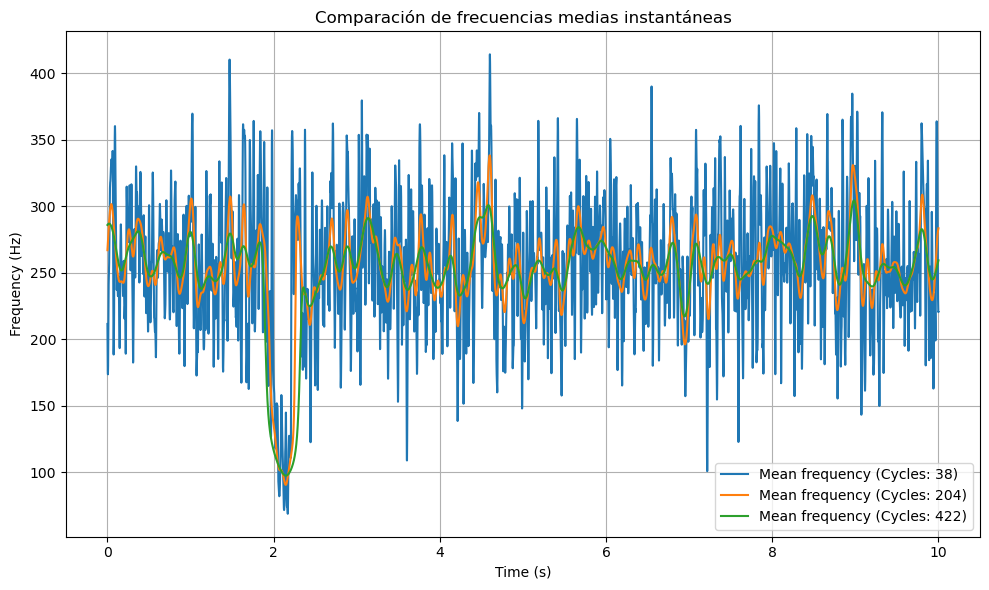

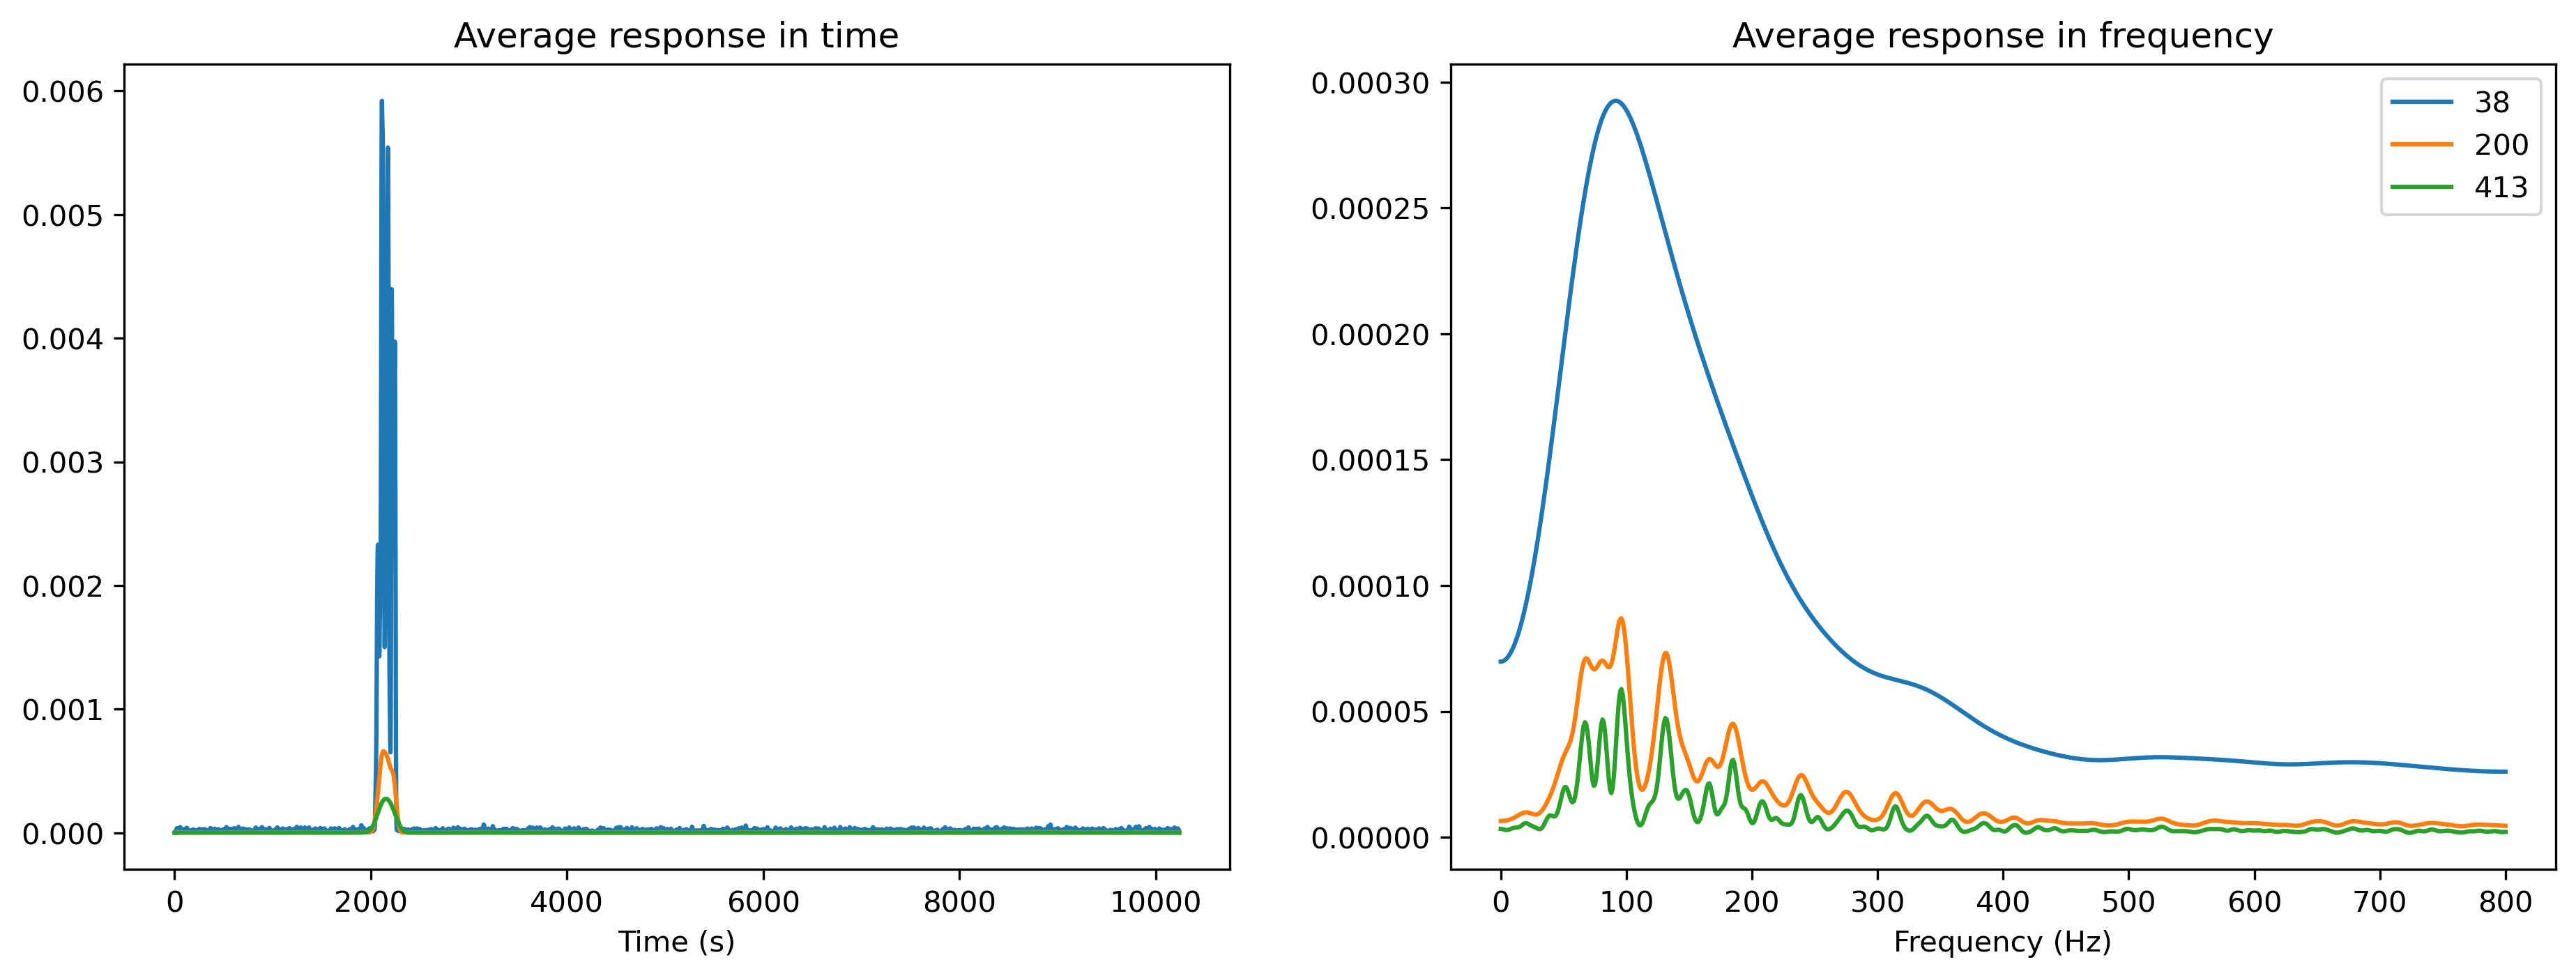

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.signal import windows

# Parámetros de la STFT con ventanas de 38 ms, 200 ms, y 413 ms (convertido a muestras)
windows_ms = [38, 200, 413]
windows_samples = [int((w / 1000) * fs) for w in windows_ms]  # Convertir a muestras

if plot_2:
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
    fig_2, ax_2 = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_stft = []
std_stft = []
times_stft = []

res_stft = []
total_scalogram_stft = []

for i, w in enumerate(windows_samples):
    # Calcular la ventana Blackman
    start_time = time.time()
    window = windows.blackman(w)
    
    # Hacer que la f de la stft tenga el mismo tamaño que las demás
    nfft = 2 * (len(freqs))
    
    # Realizar la STFT con la ventana Blackman y superposición del 50%
    #f, t, Zxx = stft(signal, fs, window=window, nfft=nfft, nperseg=w, noverlap=w//2, padded=True, scaling='psd')
    f, t, Zxx = stft(signal, fs=fs, window='blackman', nperseg=w, noverlap=w-1, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')
    
    # ax[i].pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='jet')
    
    # Calcular la representación de potencia (magnitud al cuadrado)
    Zxx_power = np.abs(Zxx) ** 2
    
    # Graficar la representación de potencia
    #plt.figure(figsize=(10, 6))
    
    end_time = time.time()
    times_stft.append(end_time - start_time)
    
    if plot_2:
        pcm = ax[i].pcolormesh(t,f, Zxx_power, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'STFT con ventana de {w} muestras ({w * 1000 // fs} ms)')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=270, labelpad=15)  # Etiqueta de la colorbar
    
        #fig.colorbar(pcm, ax=ax[i], label='Potencia')
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
    
    
    scalogram_2 = Zxx_power
    
    if np.any(np.isnan(jnp.abs(Zxx)**2)) or np.any(np.isinf(jnp.abs(Zxx)**2)):
        scalogram_2 = np.nan_to_num(jnp.abs(Zxx)**2)
        
    total_scalogram_stft.append(scalogram_2)
 
    instant_mean_freq_total = []   
    instant_mean_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)    
    
    #mean_instant_freq = np.where(freqs,np.max(scalogram_2, axis=0))
    # mean_instant = np.mean(np.where(freqs,max(scalogram_2)))
    # plt.figure()
    # plt.plot(mean_instant)
      
  
    initial_imnf = instant_mean_freq[:np.where(t >= burst_start_1)[0][0]-offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)
    
    instant_mean_freq_burst = instant_mean_freq[np.where(t >= burst_start_1)[0][0]:np.where(t >= (burst_start_1 + burst_duration_1))[0][0]]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(instant_mean_freq_burst)-offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)
    # plt.figure()
    # plt.plot(instant_mean_freq_burst)
     
    final_imnf = instant_mean_freq[np.where(t >= burst_start_1 + burst_duration_1)[0][0] + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)

    # Create time (each column is a time instant)
    tiempo = np.linspace(t[0], t[-1], len(instant_mean_freq_total))
    
    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total, label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')
        
        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)
        
        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {w})")
    
    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_stft.append(mae)
    std_stft.append(std)

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
        
    plt.tight_layout()
res_stft = superlet.compute_avg_response_resolution(total_scalogram_stft, tiempo, freqs, windows_ms)

In [32]:
mae_stft

[19.444243510797623, 8.576926771142205, 6.4959967240665]

In [67]:
offset_burst= 0

113.53727957392512
113.51079068222084
113.40866838941858


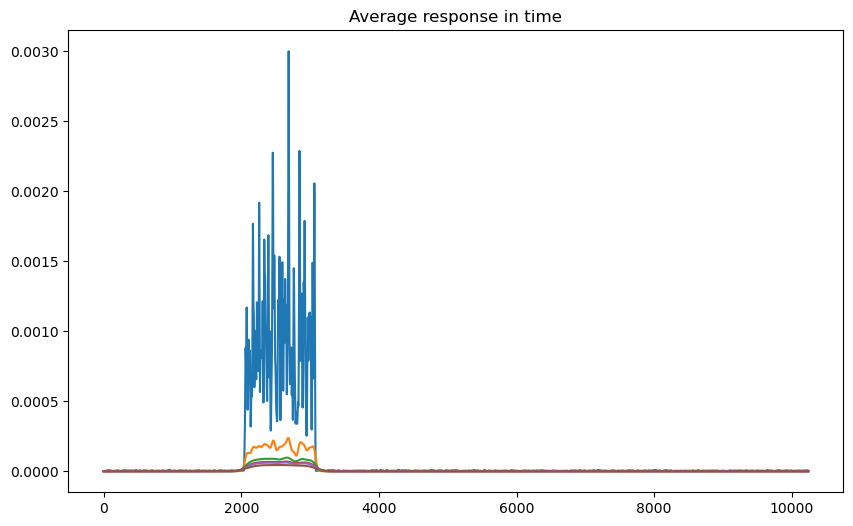

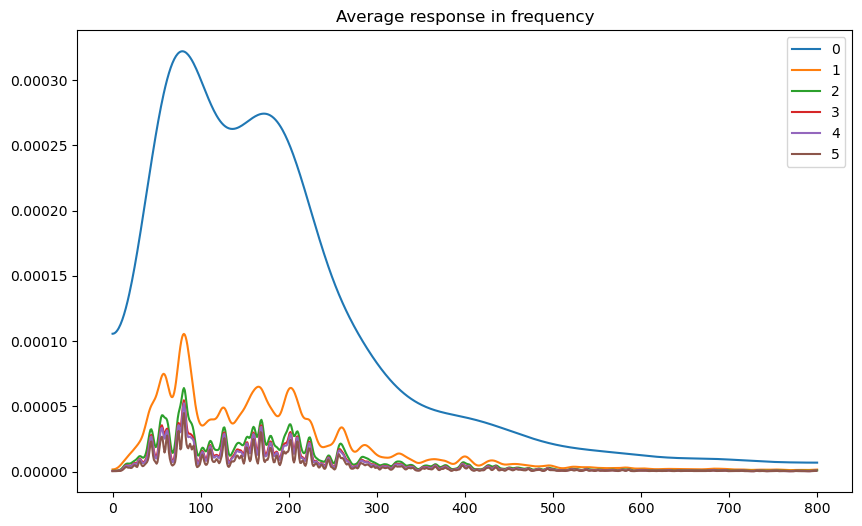

In [68]:
# Parámetros de la STFT con ventanas de 550 ms, 600 ms, y 824 ms (convertido a muestras)
windows_ms = [550, 600, 824]
windows_samples = [int((w / 1000) * fs) for w in windows_ms]  # Convertir a muestras

if plot_2:
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
    fig_2, ax_2 = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

nfft = []

Zxx_total = []

for i, w in enumerate(windows_samples):
    # Calcular la ventana Blackman
    start_time = time.time()
    window = windows.blackman(w)
    
    # Hacer que la f de la stft tenga el mismo tamaño que las demás
    nfft = 2 * (len(freqs)-1)
    
    # Realizar la STFT con la ventana Blackman y superposición del 50%
    #f, t, Zxx = stft(signal, fs, window=window, nfft=nfft, nperseg=w, noverlap=w//2, padded=True, scaling='psd')
    f, t, Zxx = stft(signal, fs=fs, window='blackman', nperseg=w, noverlap=w-1, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')
    
    # ax[i].pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='jet')
    
    # Calcular la representación de potencia (magnitud al cuadrado)
    Zxx_power = np.abs(Zxx) ** 2
    
    # Graficar la representación de potencia
    #plt.figure(figsize=(10, 6))
    
    end_time = time.time()
    times_stft.append(end_time - start_time)
    
    if plot_2:
        pcm = ax[i].pcolormesh(t,f, Zxx_power, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'STFT con ventana de {w} muestras ({w * 1000 // fs} ms)')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=270, labelpad=15)  # Etiqueta de la colorbar
    
        #fig.colorbar(pcm, ax=ax[i], label='Potencia')
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
    
    
    scalogram_2 = Zxx_power
    
    if np.any(np.isnan(jnp.abs(Zxx)**2)) or np.any(np.isinf(jnp.abs(Zxx)**2)):
        scalogram_2 = np.nan_to_num(jnp.abs(Zxx)**2)
        
    total_scalogram_stft.append(scalogram_2)
 
    instant_mean_freq_total = []   
    instant_mean_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)    
    
    #mean_instant_freq = np.where(freqs,np.max(scalogram_2, axis=0))
    # mean_instant = np.mean(np.where(freqs,max(scalogram_2)))
    # plt.figure()
    # plt.plot(mean_instant)
      
  
    initial_imnf = instant_mean_freq[:np.where(t >= burst_start_1)[0][0]-offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)
    
    instant_mean_freq_burst = instant_mean_freq[np.where(t >= burst_start_1)[0][0]:np.where(t >= (burst_start_1 + burst_duration_1))[0][0]]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(instant_mean_freq_burst)-offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)
    # plt.figure()
    # plt.plot(instant_mean_freq_burst)
     
    final_imnf = instant_mean_freq[np.where(t >= burst_start_1 + burst_duration_1)[0][0] + offset:]
    instant_mean_freq_total.extend(final_imnf)

    # Create time (each column is a time instant)
    tiempo = np.linspace(t[0], t[-1], len(instant_mean_freq_total))
    
    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total, label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')
        
        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)
        
        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {w})")
    
    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_stft.append(mae)
    std_stft.append(std)

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
        
    plt.tight_layout()

res_stft = superlet.compute_avg_response_resolution(total_scalogram_stft, tiempo, freqs)

In [ ]:
mae_stft

In [ ]:
MNF_1

In [ ]:
print(f"MAE wavelet: {mae_wavelet}")
print(f"MAE superlet: {mae_superlet}")
print(f"MAE STFT: {mae_stft}")
print(f"STD wavelet: {std_wavelet}")
print(f"STD superlet: {std_superlet}")
print(f"STD STFT: {std_stft}")
print(f"Time wavelet: {times_wavelet}")
print(f"Time superlet: {times_superlet}")
print(f"Time STFT: {times_stft}")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# 
# # Datos de ejemplo para varias SNRs
# mae_wavelet = {5: [3, 2, 4, 3.5, 4.2, 3.8], 20: [1.5, 1.2, 1.8, 1.6, 2.0, 1.9], 1: [5, 4.8, 6, 5.5, 6.5, 6.2]}
# std_wavelet = {5: [0.2, 0.3, 0.2, 0.3, 0.4, 0.3], 20: [0.1, 0.2, 0.1, 0.2, 0.3, 0.2], 1: [0.5, 0.4, 0.5, 0.6, 0.7, 0.6]}
# mae_stft = {5: [2.5, 2.2, 2.8, 3.0, 2.9, 2.7], 20: [1.0, 0.8, 1.2, 1.3, 1.4, 1.1], 1: [4.0, 3.8, 4.5, 4.2, 4.8, 4.5]}
# std_stft = {5: [0.3, 0.2, 0.4, 0.3, 0.4, 0.3], 20: [0.1, 0.2, 0.1, 0.2, 0.2, 0.1], 1: [0.4, 0.3, 0.5, 0.4, 0.5, 0.5]}
# mae_superlet = {5: [3.2, 2.9, 3.8, 3.6, 4.0, 3.9], 20: [1.8, 1.5, 2.0, 1.9, 2.2, 2.0], 1: [5.5, 5.2, 6.0, 5.8, 6.3, 6.1]}
# std_superlet = {5: [0.4, 0.3, 0.5, 0.4, 0.5, 0.4], 20: [0.2, 0.1, 0.3, 0.2, 0.3, 0.2], 1: [0.6, 0.5, 0.7, 0.6, 0.8, 0.7]}
# 
# params_wavelet = [3, 16, 33, 55, 60, 115]
# params_superlet = [
#     (3, 1, 30), (5, 1, 30), (1, 5, 40), (1, 10, 100), (1, 20, 100), (1, 30, 200)
# ]
# params_stft = [38, 200, 413, 550, 600, 824]  # Tamaños de ventana en ms
# 
# # Número de condiciones
# num_conditions = len(params_wavelet)
# x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
# bar_width = 0.25  # Ancho de las barras
# snrs = [5, 20, 1]
# 
# # Crear el gráfico de barras
# plt.figure(figsize=(18, 9))
# 
# # Iterar sobre cada SNR y graficar las barras
# for i, snr in enumerate(snrs):
#     offset = (i - 1) * bar_width  # Desplazamiento para cada SNR
#     plt.bar(
#         x + offset - bar_width, mae_stft[snr], width=bar_width, yerr=std_stft[snr], capsize=5,
#         label=f'STFT (SNR={snr})', alpha=0.7
#     )
#     plt.bar(
#         x + offset, mae_wavelet[snr], width=bar_width, yerr=std_wavelet[snr], capsize=5,
#         label=f'Wavelet (SNR={snr})', alpha=0.7
#     )
#     plt.bar(
#         x + offset + bar_width, mae_superlet[snr], width=bar_width, yerr=std_superlet[snr], capsize=5,
#         label=f'Superlet (SNR={snr})', alpha=0.7
#     )
# 
# # Configuración de etiquetas en el eje x con los parámetros específicos
# labels = [
#     f"W={p_stft} ms\nc={p_w}\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
#     for p_w, p_s, p_stft in zip(params_wavelet, params_superlet, params_stft)
# ]
# 
# plt.xticks(x, labels, rotation=90, ha='center', fontsize=14)
# plt.ylabel('MAE (Hz)', fontsize=14)
# plt.title('Comparison of Techniques for Multiple SNRs', fontsize=18)
# plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
# 
# # Ajustar el layout para mejorar visualización de etiquetas
# plt.tight_layout()
# 
# # Mostrar el gráfico
# plt.show()


In [ ]:
params_wavelet = [3, 16, 33, 55, 60, 115]
params_superlet = [
    (3, 1, 30), (5, 1, 30), (1, 5, 40), (1, 10, 100), (1, 20, 100), (1, 30, 200)
]
params_stft = [38, 200, 413, 550, 600, 824]  # Tamaños de ventana en ms

# Número de condiciones
num_conditions = len(mae_wavelet)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft, width=bar_width, yerr=std_stft, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet, width=bar_width, yerr=std_wavelet, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet, width=bar_width, yerr=std_superlet, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, params_superlet, params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.ylabel('MAE (Hz)')
plt.title('Comparison (SNR = ' + str(SNR) +')', fontsize=18)
plt.legend(fontsize=14)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Hacer solo la primera vez

In [ ]:
MAES = {
    'stft': [],
    'wavelet': [],
    'superlet': [],
    'MNF': []
}

In [ ]:
MAES['wavelet'].append(mae_wavelet)
MAES['stft'].append(mae_stft)
MAES['superlet'].append(mae_superlet)

In [ ]:
MAES

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parámetros
params_wavelet = [3, 16, 33, 55, 60, 115]
params_superlet = [
    (3, 1, 30), (5, 1, 30), (1, 5, 40), (1, 10, 100), (1, 20, 100), (1, 30, 200)
]
params_stft = [38, 200, 413, 550, 600, 824]  # Tamaños de ventana en ms

# Datos MAE para cada técnica y SNR
mae_stft = MAES['stft']

mae_wavelet = MAES['wavelet']

mae_superlet = MAES['superlet']

snr_labels = ["Sin SNR", "5 dB", "20 dB"]

# Configuración del gráfico
num_params = len(params_stft)  # Número de parámetros (6 en este caso)
num_snr = len(snr_labels)  # Número de niveles de ruido (3)
x = np.arange(num_params)  # Posiciones base para cada grupo de parámetros
bar_width = 0.1  # Ancho de cada barra
group_width = bar_width * num_snr  # Espacio reservado para cada grupo de barras

# Crear el gráfico
plt.figure(figsize=(18, 8))

# Dibujar barras para cada técnica y SNR
for i in range(num_snr):  # Iterar sobre niveles de SNR
    # Dibujar barras para STFT
    plt.bar(x - 0.01 - group_width + i * bar_width, 
            [np.array(mae_stft[i])[k] for k in range(num_params)], 
            width=bar_width, label=f'STFT ({snr_labels[i]})', alpha=0.7)

    # Dibujar barras para Wavelet
    plt.bar(x + i * bar_width, 
            [np.array(mae_wavelet[i])[k] for k in range(num_params)], 
            width=bar_width, label=f'Wavelet ({snr_labels[i]})', alpha=0.7)

    # Dibujar barras para Superlet
    plt.bar(x + 0.01 + group_width + i * bar_width, 
            [np.array(mae_superlet[i])[k] for k in range(num_params)], 
            width=bar_width, label=f'Superlet ({snr_labels[i]})', alpha=0.7)

# Etiquetas para los grupos de parámetros
labels = [
    f"W={p_stft} ms\nc={p_wavelet}\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, params_superlet, params_stft)
]

# Configurar eje X y otros detalles
plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
plt.ylabel('MAE (Hz)', fontsize=14)
# plt.title('Comparación de MAE por técnica, parámetro y nivel de ruido', fontsize=16)
plt.legend(fontsize=10, ncol=1)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


# COMPUTE RESOLUTION

ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

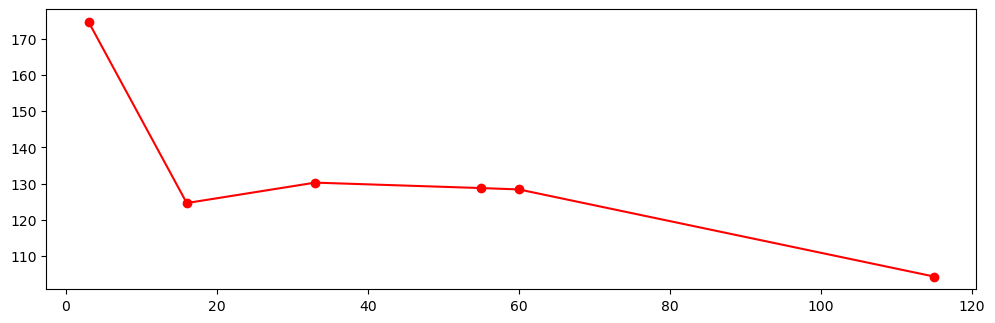

In [63]:
# Graficar resoluciones para SNR específico
selected_snr_index = 2  # Índice para SNR = 0
rayleigh_limit = 1 / (4 * np.pi)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot([3, 16, 33, 55, 60, 115], [r[1] for r in res_wavelet], 'ro-', label="Wavelet (Frequency)")
plt.plot([3, 16, 33, 55, 60, 115], [r[1] for r in res_stft], 'bo-', label="STFT (Frequency)")
plt.plot([3, 16, 33, 55, 60, 115], [r[1] for r in res_superlet], 'go-', label="Superlet (Frequency)")
plt.axhline(rayleigh_limit, color='k', linestyle='--', label="Rayleigh Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Frequency Resolution (Hz)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot([3, 16, 33, 55, 60, 115], [r[0] for r in res_wavelet], 'ro-', label="Wavelet (Time)")
plt.plot([3, 16, 33, 55, 60, 115], [r[0] for r in res_stft], 'bo-', label="STFT (Time)")
plt.plot([3, 16, 33, 55, 60, 115], [r[0] for r in res_superlet], 'go-', label="Superlet (Time)")
plt.axhline(1/MNF_1[0], color='k', linestyle='--', label="Temporal Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Time Resolution (s)")
plt.legend()

plt.tight_layout()
plt.show()